In [1]:
import numpy as np
import pandas as pd

import pickle
import random
import os
import time
from datetime import datetime
from pathlib import Path
import glob
import json
from tqdm import tqdm

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
from PIL import Image
#%matplotlib inline
plotly.offline.init_notebook_mode(connected=True)
sns.set_style('darkgrid')

from xyz10.io_f_mod import read_data_file
from xyz10.visualize_f_mod import visualize_trajectory, save_figure_to_image

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelBinarizer, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import resample, shuffle

# os.environ['CUDA_VISIBLE_DEVICES'] = "0"  # "0" = GPU_on, "-1" = GPU_off

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import TensorBoard
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

#%load_ext tensorboard  # extension for notebook

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


 MODELING/FITTING
- DNN XYF model (small vs large) per site: length = 1x dT
    > Train/Validation = random record split
    
=> 1 Model + 1 Scaller per site (in dictionary)

In [2]:
def load_data(site_id, fraction_bssid, data_file="mode-count_fraction-10000_mix-bssid"):
    print("Loading Data...")
    path = "./data_out/full24/"  # full24/compact24
    file_name = f"{site_id}_{data_file}.pkl"
    
    f_list = features_list(site_id, fraction_bssid)

    return f_list, pickle.load(open(path+file_name, "rb"))[f_list]

def features_list(site_id, fraction_bssid, bssid_mode="weight"):
    
    #bssid_mode = ["count", "rssi", "weight"]
    
    test_bssid = pickle.load(open("./data_out/test_bssid_ranks.pkl", "rb"))
    train_bssid = pickle.load(open("./data_out/train_24IDs_standardF_bssid_ranks.pkl", "rb"))

    if fraction_bssid < 1:
        _test_bssid = test_bssid[bssid_mode][site_id].bssid[:int(fraction_bssid*len(test_bssid[bssid_mode][site_id]))]
        _train_bssid = train_bssid[bssid_mode][site_id].bssid[:int(fraction_bssid*len(train_bssid[bssid_mode][site_id]))]
    else:
        _test_bssid = test_bssid[bssid_mode][site_id].bssid[:int(fraction_bssid)]
        _train_bssid = train_bssid[bssid_mode][site_id].bssid[:int(fraction_bssid)]
    
    mix_bssid = pd.concat([_test_bssid,  _train_bssid]).unique()
    
    _list = _train_bssid.unique().tolist() #mix_bssid.tolist()
    _list_d = ["time", "trace", "x", "y", "f"]
    
    for record in _list:
        _list_d.append(record)
        _list_d.append(record+"_D")
        
    return _list_d

def preprocess_data(featured_data, target_type="XY", data_fraction=1, delay_lim=1000, rssi_lim=-94,  random_state=123):
    print(f"Processing Data of shape {featured_data[1].shape} with target->{target_type}...")

    shuffled_data = shuffle(featured_data[1], random_state=random_state)

    columns_to_drop = ["time", "trace"]
    _ = [shuffled_data.pop(col) for col in columns_to_drop]

    shuffled_data = shuffled_data.iloc[:int(shuffled_data.shape[0] * data_fraction), :]
       
    y_x = shuffled_data.pop("x")
    y_y = shuffled_data.pop("y")
    y_f = shuffled_data.pop("f")

    x = shuffled_data
    
    x[x > delay_lim] = delay_lim
    x[x < rssi_lim] = rssi_lim
    
    if "F0" in target_type:
        binarizer = LabelBinarizer()
        y = binarizer.fit_transform(y_f)
    elif "F" in target_type:
        binarizer = LabelBinarizer()
        y = binarizer.fit_transform(y_f)
        x = pd.concat([x, y_x, y_y], axis=1)
    elif "XY0" in target_type:
        y = pd.concat([y_x, y_y], axis=1)
        encoder_dummy = "None"
    else:
        encoder = LabelBinarizer()#OneHotEncoder(sparse=False)
        y = pd.concat([y_x, y_y], axis=1)
        y_f = encoder.fit_transform(y_f)
        #print(y_f.shape)
        x = np.concatenate((x, y_f), axis=1)#pd.concat([x, y_f], axis=1)
    
    train_x, val_x, train_y, val_y = train_test_split(x, y, random_state=random_state)
    
    train_x, val_x = np.array(train_x), np.array(val_x)
    
    if "F" in target_type:
        train_y_f = np.array(train_y)#.reshape((-1, 1))
        val_y_f = np.array(val_y)#.reshape((-1, 1))
    else:
        train_y_x, train_y_y = np.array(train_y)[:, 0], np.array(train_y)[:, 1]
        val_y_x, val_y_y = np.array(val_y)[:, 0], np.array(val_y)[:, 1]
        
    scaler = StandardScaler()  # RobustScaler()  /StandardScaler()/ MinMaxScaler
    train_x = scaler.fit_transform(train_x)
    val_x = scaler.transform(val_x)
        
    if "F" in target_type:
        return featured_data[0], scaler, binarizer, train_x, val_x, train_y_f, val_y_f
        #print(f"shape of train_y:", shape)
    elif "XY0" in target_type:
        return featured_data[0], scaler, encoder_dummy, train_x, val_x, train_y_x, train_y_y, val_y_x, val_y_y
    else:
        return featured_data[0], scaler, encoder, train_x, val_x, train_y_x, train_y_y, val_y_x, val_y_y
        

def save_models(models24, model_type="XY", models="models24_bssid10k_SP_count_mix"):
    print("Saving Models...")
    
    idx = int(time.time())
    model_name = f"{models}_{idx}/"
    model_path = "./saved_models/"+ model_name

    if not os.path.exists(model_path):
        os.makedirs(model_path)

    for site_id in tqdm(models24.keys()):

        models24[site_id][3].save(model_path + site_id + f"_{model_type}")
        with open(model_path + site_id + f"_{model_type}/features_list.pkl", "wb") as f:
            pickle.dump(models24[site_id][0], f)
        with open(model_path + site_id + f"_{model_type}/scaler.pkl", "wb") as f:
            pickle.dump(models24[site_id][1], f)
        with open(model_path + site_id + f"_{model_type}/f_binarizer.pkl", "wb") as f:
            pickle.dump(models24[site_id][2], f)
            
def calculate_global_metrics(comparison):

    train_mae = 0
    val_mae = 0

    for comparison_train, comparison_val in comparison:

        train_mae += comparison_train.mean_abs_error[comparison_train.index[-1]]
        val_mae += comparison_val.mean_abs_error[comparison_val.index[-1]]

    comp_length = len(comparison)
    
    train_mae /= comp_length
    val_mae /= comp_length

    print(f"Global Train/Validation MAE: {train_mae}/{val_mae}")
            
def xy_loss_metric(y_true, y_pred):
    e_xy = tf.sqrt(tf.square(y_true[:, 0] - y_pred[:, 0]) +  tf.square(y_true[:, 1] - y_pred[:, 1])) 
    return tf.reduce_mean(e_xy, axis=-1)

def DNN(site_id, target_type, train_x, val_x, train_y, val_y, w_f = 10, drop=0.1, learning_rate=0.005, epochs=200, batch=6): 
    print(f"Fitting {target_type}-Model...")
    
    epoch_iterations = 100
    
    features_count = train_x.shape[1]
    targets_count = train_y.shape[1]
    records_num = train_y.shape[0]
        
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-7, amsgrad=False)  # "adam"
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=10, min_lr=1e-20)
    earlystop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True)
        
    if batch==0:
        batch = int(np.log2(records_num/epoch_iterations))
        
    METRICS = [
        #tf.keras.metrics.MeanAbsoluteError(name="mae", dtype=None)
        #xyf_loss_metric,
        tf.keras.metrics.RootMeanSquaredError(name="rmse", dtype=None)
    ]       
    
    MODEL_NAME = f"Site-{site_id}_{target_type}_bssid-f{features_count}_triaL3x{w_f}_LR{learning_rate}_ep{epochs}_bch{batch}_{int(time.time())}"
    tensorboard = TensorBoard(log_dir=f"log/Neurals/{MODEL_NAME}", histogram_freq=1)
            
    model = keras.Sequential([
        #layers.BatchNormalization(input_shape=(features_count,)),
        layers.Dense(int(features_count*w_f if w_f < 1 else w_f), activation="relu", input_shape=(features_count,)),
        #layers.Dense(int(features_count*w_f if w_f < 1 else w_f), activation="relu"),
        #layers.Dropout(drop),
        
        #layers.BatchNormalization(),
        layers.Dense(int(0.5*features_count*w_f if w_f <= 1 else w_f), activation="relu"),
        #layers.Dropout(drop),
        #layers.BatchNormalization(),
        layers.Dense(int(0.25*features_count*w_f if w_f <= 1 else w_f), activation="relu"),
        #layers.Dropout(drop),
                        
        layers.Dense(targets_count, activation='softmax' if "F" in target_type else "linear")
    ])

    model.compile(optimizer=optimizer,
                  #loss="mae",
                  loss="categorical_crossentropy" if "F" in target_type else "mse",#xy_loss_metric,#"mse",
                  #loss="mse", #xy_loss_metric if target_type=="XY" else "mse",
                  metrics=['accuracy'] if "F" in target_type else METRICS)
    
    #model.summary()  
    
    fit = model.fit(train_x, train_y,
                    validation_data=(val_x,  val_y),
                    batch_size=2**batch,
                    epochs=epochs,
                    verbose=0,
                    callbacks=[tensorboard,  reduce_lr, earlystop]
                   )
        
    #fit_progress = pd.DataFrame(fit.history)
    #fit_progress.loc[:, ["accuracy", "val_accuracy"]].plot()
    #fit_progress.loc[:, ["loss", "val_loss"]].plot()

    return model

***
FLOOR PREDICTION MODELS (with XY as features)
***

In [3]:
models24_f = {}
train_val_comparison_f = []
num_s = 0

site_ids_shapes = {"5d27075f03f801723c2e360f": (73141, 14063), "5dc8cea7659e181adb076a3f": (57849, 9733), "5dbc1d84c1eb61796cf7c010": (61727, 9043), "5da138b74db8ce0c98bd4774": (56668, 7075),
                   "5d2709c303f801723c3299ee": (33368, 11667), "5da958dd46f8266d0737457b": (47796, 7003), "5d2709bb03f801723c32852c": (44009, 4909), "5d27096c03f801723c31e5e0": (19337, 9933),
                   "5a0546857ecc773753327266": (26532, 6799), "5c3c44b80379370013e0fd2b": (29359, 6131), "5d27097f03f801723c320d97": (35121, 4985), "5da1382d4db8ce0c98bbe92e": (28975, 5729),
                   "5d2709b303f801723c327472": (32449, 3831), "5d2709d403f801723c32bd39": (23545, 4283), "5da138764db8ce0c98bcaa46": (27771, 3781), "5da1383b4db8ce0c98bc11ab": (34396, 3055),
                   "5d2709e003f801723c32d896": (29752, 2623), "5da138754db8ce0c98bca82f": (13795, 3259), "5da1389e4db8ce0c98bd0547": (17795, 2047), "5da138314db8ce0c98bbf3a0": (13122, 2429),
                   "5d2709a003f801723c3251bf": (9345, 2509), "5d27099f03f801723c32511d": (9700, 1855), "5da138364db8ce0c98bc00f1": (5555, 1649), "5da138274db8ce0c98bbd3d2": (6338, 985)}

site_ids_lrate = {"5d27075f03f801723c2e360f": 0.0007, "5dc8cea7659e181adb076a3f": 0.0009, "5dbc1d84c1eb61796cf7c010": 0.0008, "5da138b74db8ce0c98bd4774": 0.0009, 
                  "5d2709c303f801723c3299ee": 0.0015, "5da958dd46f8266d0737457b": 0.001, "5d2709bb03f801723c32852c": 0.0011, "5d27096c03f801723c31e5e0": 0.0026, 
                  "5a0546857ecc773753327266": 0.0019, "5c3c44b80379370013e0fd2b": 0.0017, "5d27097f03f801723c320d97": 0.0014, "5da1382d4db8ce0c98bbe92e": 0.0017, 
                  "5d2709b303f801723c327472": 0.002, "5d2709d403f801723c32bd39": 0.002, "5da138764db8ce0c98bcaa46": 0.002, "5da1383b4db8ce0c98bc11ab": 0.001, 
                  "5d2709e003f801723c32d896": 0.002, "5da138754db8ce0c98bca82f": 0.004, "5da1389e4db8ce0c98bd0547": 0.003, "5da138314db8ce0c98bbf3a0": 0.004, 
                  "5d2709a003f801723c3251bf": 0.005, "5d27099f03f801723c32511d": 0.005, "5da138364db8ce0c98bc00f1": 0.009, "5da138274db8ce0c98bbd3d2": 0.008}

site_ids = ["5da138274db8ce0c98bbd3d2"]

r_seeds = [123]#[1, 12, 123, 1234, 12345]

for r_seed in r_seeds:

    for site_id in site_ids_shapes.keys():#site_ids:#site_ids_shapes.keys():#site_ids:
        num_s += 1
        print(f"Working on #{num_s}: Site-{site_id}")
        #========================================================================================
        
        f_list, scaler_f, target_binarizer_f, train_x, val_x, train_y_f, val_y_f = preprocess_data(load_data(site_id, 10000), target_type="F",
                                                                                                   data_fraction=1, random_state=r_seed,
                                                                                                   delay_lim=4000, rssi_lim=-94)
        model_f = DNN(site_id=site_id, target_type="F",
                      train_x=train_x, val_x=val_x,
                      train_y=train_y_f, val_y=val_y_f,
                      w_f=0.1, drop=0.01, learning_rate=round(50/site_ids_shapes[site_id][0], 4), epochs=100, batch=0)

        models24_f[site_id] = [f_list[5:], scaler_f, target_binarizer_f, model_f]

        #========================================================================================
        # sanity check section
        predict_columns = ["predict_F"]
        real_columns = ["real_F"]
        col_dic = {0: "_F"}

        predictions_train_f = pd.DataFrame(target_binarizer_f.inverse_transform(model_f.predict(train_x)), columns=predict_columns)
        comparison_train_f = pd.concat([pd.DataFrame(target_binarizer_f.inverse_transform(train_y_f), columns=real_columns),
                                      predictions_train_f], axis=1)
        predictions_val_f = pd.DataFrame(target_binarizer_f.inverse_transform(model_f.predict(val_x)), columns=predict_columns)
        comparison_val_f = pd.concat([pd.DataFrame(target_binarizer_f.inverse_transform(val_y_f), columns=real_columns),
                                    predictions_val_f], axis=1)

        for col_i, col in enumerate(predict_columns):
            for train_valid in [comparison_train_f, comparison_val_f]:
                train_valid["abs_error"+col_dic[col_i]] = np.abs(train_valid[real_columns[col_i]] - train_valid[col])

        for train_valid in [comparison_train_f, comparison_val_f]:
            mean_error = 15*(train_valid["abs_error_F"])
            train_valid["mean_abs_error"] = mean_error.cumsum()/train_valid.shape[0]

            train_valid["accurate"] = np.array(train_valid["abs_error_F"] < 0.5).astype(int)
            train_valid["floor_accuracy"] = train_valid["accurate"].cumsum()/train_valid.shape[0]

        print(f"Predictions (train/validation) #{num_s}: Site-{site_id}")
        display(comparison_train_f[["mean_abs_error", "floor_accuracy"]].tail(1))
        display(comparison_val_f[["mean_abs_error", "floor_accuracy"]].tail(1))

        train_val_comparison_f.append([comparison_train_f, comparison_val_f])
        #========================================================================================
        display(comparison_val_f.describe())
        display(comparison_val_f[comparison_val_f.accurate < 1])

        keras.backend.clear_session()
        #break
    print("Finished fitting")
    calculate_global_metrics(train_val_comparison_f)
    save_models(models24_f, "F", f"models24_Fcat_F_R{r_seed}")
    print("Finished Models Saving")
    #%tensorboard --logdir log/Neurals  # commandline to start tensorboard

Working on #1: Site-5d27075f03f801723c2e360f
Loading Data...
Processing Data of shape (73141, 14063) with target->F...
Fitting F-Model...
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
Predictions (train/validation) #1: Site-5d27075f03f801723c2e360f


,mean_abs_error,floor_accuracy
54854,0.0,1.0


,mean_abs_error,floor_accuracy
18285,0.002461,0.999945


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
count,18286.000000,18286.000000,18286.000000,18286.000000,18286.000000,18286.000000
mean,1.126764,1.126928,0.000164,0.000419,0.999945,0.500018
std,1.402879,1.402806,0.022185,0.000925,0.007395,0.288670
min,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000055
25%,0.000000,0.000000,0.000000,0.000000,1.000000,0.250041
50%,1.000000,1.000000,0.000000,0.000000,1.000000,0.500027
75%,2.000000,2.000000,0.000000,0.000000,1.000000,0.750014
max,6.000000,6.000000,3.000000,0.002461,1.000000,0.999945


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
15174,-1,2,3,0.002461,0,0.829815


Working on #2: Site-5dc8cea7659e181adb076a3f
Loading Data...
Processing Data of shape (57849, 9733) with target->F...
Fitting F-Model...
Predictions (train/validation) #2: Site-5dc8cea7659e181adb076a3f


,mean_abs_error,floor_accuracy
43385,0.009335,0.999516


,mean_abs_error,floor_accuracy
14462,0.01452,0.999378


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
count,14463.000000,14463.000000,14463.000000,14463.000000,14463.000000,14463.000000
mean,2.351241,2.350273,0.000968,0.009213,0.999378,0.499631
std,2.031077,2.031789,0.040726,0.003564,0.024939,0.288535
min,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000069
25%,1.000000,1.000000,0.000000,0.006223,1.000000,0.249775
50%,2.000000,2.000000,0.000000,0.009334,1.000000,0.499620
75%,4.000000,4.000000,0.000000,0.012446,1.000000,0.749464
max,6.000000,6.000000,2.000000,0.014520,1.000000,0.999378


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
127,2,0,2,0.002074,0,0.008781
774,2,0,2,0.004149,0,0.053447
1159,1,0,1,0.005186,0,0.079997
1683,1,0,1,0.006223,0,0.116158
4314,1,0,1,0.007260,0,0.298002
7159,2,0,2,0.009334,0,0.494641
7405,2,0,2,0.011408,0,0.511581
10423,1,0,1,0.012446,0,0.720183
12745,2,0,2,0.014520,0,0.880661


Working on #3: Site-5dbc1d84c1eb61796cf7c010
Loading Data...
Processing Data of shape (61727, 9043) with target->F...
Fitting F-Model...
Predictions (train/validation) #3: Site-5dbc1d84c1eb61796cf7c010


,mean_abs_error,floor_accuracy
46294,0.0,1.0


,mean_abs_error,floor_accuracy
15431,0.0,1.0


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
count,15432.000000,15432.000000,15432.0,15432.0,15432.0,15432.000000
mean,3.500583,3.500583,0.0,0.0,1.0,0.500032
std,2.365314,2.365314,0.0,0.0,0.0,0.288684
min,-1.000000,-1.000000,0.0,0.0,1.0,0.000065
25%,2.000000,2.000000,0.0,0.0,1.0,0.250049
50%,4.000000,4.000000,0.0,0.0,1.0,0.500032
75%,5.000000,5.000000,0.0,0.0,1.0,0.750016
max,7.000000,7.000000,0.0,0.0,1.0,1.000000


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy


Working on #4: Site-5da138b74db8ce0c98bd4774
Loading Data...
Processing Data of shape (56668, 7075) with target->F...
Fitting F-Model...
Predictions (train/validation) #4: Site-5da138b74db8ce0c98bd4774


,mean_abs_error,floor_accuracy
42500,0.001059,0.999929


,mean_abs_error,floor_accuracy
14166,0.012706,0.999576


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
count,14167.000000,14167.000000,14167.000000,14167.000000,14167.000000,14167.000000
mean,1.074610,1.073904,0.000847,0.008472,0.999576,0.499747
std,1.928558,1.928183,0.051786,0.004150,0.020576,0.288554
min,-2.000000,-2.000000,0.000000,0.000000,0.000000,0.000071
25%,-1.000000,-1.000000,0.000000,0.007412,1.000000,0.249841
50%,1.000000,1.000000,0.000000,0.009529,1.000000,0.499682
75%,3.000000,3.000000,0.000000,0.012706,1.000000,0.749594
max,4.000000,4.000000,5.000000,0.012706,1.000000,0.999576


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
2282,4,-1,5,0.005294,0,0.161079
2394,4,3,1,0.006353,0,0.168914
2840,-1,0,1,0.007412,0,0.200325
3804,3,2,1,0.008470,0,0.268300
5523,0,-1,1,0.009529,0,0.389567
10224,4,1,3,0.012706,0,0.721324


Working on #5: Site-5d2709c303f801723c3299ee
Loading Data...
Processing Data of shape (33368, 11667) with target->F...
Fitting F-Model...
Predictions (train/validation) #5: Site-5d2709c303f801723c3299ee


,mean_abs_error,floor_accuracy
25025,0.0,1.0


,mean_abs_error,floor_accuracy
8341,0.001798,0.99988


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
count,8342.000000,8342.000000,8342.000000,8342.000000,8342.000000,8342.000000
mean,2.794294,2.794174,0.000120,0.000251,0.999880,0.500043
std,2.238319,2.238442,0.010949,0.000623,0.010949,0.288668
min,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000120
25%,1.000000,1.000000,0.000000,0.000000,1.000000,0.250090
50%,3.000000,3.000000,0.000000,0.000000,1.000000,0.500060
75%,4.000000,4.000000,0.000000,0.000000,1.000000,0.750030
max,8.000000,8.000000,1.000000,0.001798,1.000000,0.999880


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
7178,1,0,1,0.001798,0,0.860465


Working on #6: Site-5da958dd46f8266d0737457b
Loading Data...
Processing Data of shape (47796, 7003) with target->F...
Fitting F-Model...
Predictions (train/validation) #6: Site-5da958dd46f8266d0737457b


,mean_abs_error,floor_accuracy
35846,0.0,1.0


,mean_abs_error,floor_accuracy
11948,0.0,1.0


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
count,11949.000000,11949.000000,11949.0,11949.0,11949.0,11949.000000
mean,1.674199,1.674199,0.0,0.0,1.0,0.500042
std,2.043441,2.043441,0.0,0.0,0.0,0.288687
min,-1.000000,-1.000000,0.0,0.0,1.0,0.000084
25%,0.000000,0.000000,0.0,0.0,1.0,0.250063
50%,1.000000,1.000000,0.0,0.0,1.0,0.500042
75%,3.000000,3.000000,0.0,0.0,1.0,0.750021
max,6.000000,6.000000,0.0,0.0,1.0,1.000000


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy


Working on #7: Site-5d2709bb03f801723c32852c
Loading Data...
Processing Data of shape (44009, 4909) with target->F...
Fitting F-Model...
Predictions (train/validation) #7: Site-5d2709bb03f801723c32852c


,mean_abs_error,floor_accuracy
33005,0.0,1.0


,mean_abs_error,floor_accuracy
11002,0.010906,0.999455


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
count,11003.000000,11003.000000,11003.000000,11003.000000,11003.000000,11003.000000
mean,0.715078,0.715259,0.000727,0.007655,0.999455,0.499674
std,1.136949,1.136515,0.035665,0.003401,0.023346,0.288534
min,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000091
25%,0.000000,0.000000,0.000000,0.006816,1.000000,0.249796
50%,1.000000,1.000000,0.000000,0.008180,1.000000,0.499682
75%,2.000000,2.000000,0.000000,0.010906,1.000000,0.749477
max,3.000000,3.000000,3.000000,0.010906,1.000000,0.999455


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
347,-1,0,1,0.001363,0,0.031537
780,-1,0,1,0.002727,0,0.070799
2614,3,0,3,0.006816,0,0.237390
4118,0,1,1,0.008180,0,0.373989
5695,0,1,1,0.009543,0,0.517223
7459,0,1,1,0.010906,0,0.677452


Working on #8: Site-5d27096c03f801723c31e5e0
Loading Data...
Processing Data of shape (19337, 9933) with target->F...
Fitting F-Model...
Predictions (train/validation) #8: Site-5d27096c03f801723c31e5e0


,mean_abs_error,floor_accuracy
14501,0.0,1.0


,mean_abs_error,floor_accuracy
4834,0.015512,0.999586


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
count,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000
mean,1.996484,1.997518,0.001034,0.007580,0.999586,0.499867
std,1.937423,1.938118,0.059293,0.007034,0.020336,0.288543
min,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000207
25%,0.000000,0.000000,0.000000,0.000000,1.000000,0.250155
50%,2.000000,2.000000,0.000000,0.003102,1.000000,0.499897
75%,4.000000,4.000000,0.000000,0.015512,1.000000,0.749638
max,5.000000,5.000000,4.000000,0.015512,1.000000,0.999586


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
1401,4,5,1,0.003102,0,0.289762
2740,1,5,4,0.015512,0,0.566494


Working on #9: Site-5a0546857ecc773753327266
Loading Data...
Processing Data of shape (26532, 6799) with target->F...
Fitting F-Model...
Predictions (train/validation) #9: Site-5a0546857ecc773753327266


,mean_abs_error,floor_accuracy
19898,0.002261,0.999849


,mean_abs_error,floor_accuracy
6632,0.009046,0.999397


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
count,6633.000000,6633.000000,6633.000000,6633.000000,6633.000000,6633.000000
mean,1.092266,1.092869,0.000603,0.005403,0.999397,0.499715
std,1.391510,1.391036,0.024551,0.003268,0.024551,0.288486
min,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000151
25%,0.000000,0.000000,0.000000,0.002261,1.000000,0.249962
50%,1.000000,1.000000,0.000000,0.006784,1.000000,0.499623
75%,2.000000,2.000000,0.000000,0.009046,1.000000,0.749435
max,3.000000,3.000000,1.000000,0.009046,1.000000,0.999397


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
821,1,2,1,0.002261,0,0.123775
2230,-1,0,1,0.004523,0,0.336047
3267,-1,0,1,0.006784,0,0.492236
4367,-1,0,1,0.009046,0,0.657923


Working on #10: Site-5c3c44b80379370013e0fd2b
Loading Data...
Processing Data of shape (29359, 6131) with target->F...
Fitting F-Model...
Predictions (train/validation) #10: Site-5c3c44b80379370013e0fd2b


,mean_abs_error,floor_accuracy
22018,0.0,1.0


,mean_abs_error,floor_accuracy
7339,0.0,1.0


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
count,7340.000000,7340.000000,7340.0,7340.0,7340.0,7340.000000
mean,0.840054,0.840054,0.0,0.0,1.0,0.500068
std,1.411621,1.411621,0.0,0.0,0.0,0.288695
min,-1.000000,-1.000000,0.0,0.0,1.0,0.000136
25%,0.000000,0.000000,0.0,0.0,1.0,0.250102
50%,1.000000,1.000000,0.0,0.0,1.0,0.500068
75%,2.000000,2.000000,0.0,0.0,1.0,0.750034
max,4.000000,4.000000,0.0,0.0,1.0,1.000000


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy


Working on #11: Site-5d27097f03f801723c320d97
Loading Data...
Processing Data of shape (35121, 4985) with target->F...
Fitting F-Model...
Predictions (train/validation) #11: Site-5d27097f03f801723c320d97


,mean_abs_error,floor_accuracy
26339,0.0,1.0


,mean_abs_error,floor_accuracy
8780,0.022207,0.999203


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
count,8781.000000,8781.000000,8781.000000,8781.000000,8781.000000,8781.000000
mean,1.777474,1.776677,0.001480,0.008233,0.999203,0.499741
std,1.707387,1.706715,0.057452,0.007741,0.028225,0.288412
min,-2.000000,-2.000000,0.000000,0.000000,0.000000,0.000114
25%,1.000000,1.000000,0.000000,0.000000,1.000000,0.250085
50%,2.000000,2.000000,0.000000,0.006833,1.000000,0.499829
75%,3.000000,3.000000,0.000000,0.013666,1.000000,0.749459
max,4.000000,4.000000,3.000000,0.022207,1.000000,0.999203


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
3047,1,2,1,0.001708,0,0.346999
3647,4,1,3,0.006833,0,0.415215
4488,1,2,1,0.008541,0,0.510876
4953,4,2,2,0.011958,0,0.563717
5770,1,2,1,0.013666,0,0.656645
7209,4,1,3,0.018791,0,0.820408
8026,4,2,2,0.022207,0,0.913336


Working on #12: Site-5da1382d4db8ce0c98bbe92e
Loading Data...
Processing Data of shape (28975, 5729) with target->F...
Fitting F-Model...
Predictions (train/validation) #12: Site-5da1382d4db8ce0c98bbe92e


,mean_abs_error,floor_accuracy
21730,0.008283,0.999448


,mean_abs_error,floor_accuracy
7243,0.006212,0.999586


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
count,7244.000000,7244.000000,7244.000000,7244.000000,7244.000000,7244.000000
mean,1.091524,1.091938,0.000414,0.003468,0.999586,0.499838
std,1.684747,1.684437,0.020348,0.001007,0.020348,0.288641
min,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000138
25%,0.000000,0.000000,0.000000,0.002071,1.000000,0.249965
50%,1.000000,1.000000,0.000000,0.004141,1.000000,0.499793
75%,3.000000,3.000000,0.000000,0.004141,1.000000,0.749758
max,4.000000,4.000000,1.000000,0.006212,1.000000,0.999586


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
50,0,1,1,0.002071,0,0.006902
2319,-1,0,1,0.004141,0,0.319989
7232,-1,0,1,0.006212,0,0.998067


Working on #13: Site-5d2709b303f801723c327472
Loading Data...
Processing Data of shape (32449, 3831) with target->F...
Fitting F-Model...
Predictions (train/validation) #13: Site-5d2709b303f801723c327472


,mean_abs_error,floor_accuracy
24335,0.0,1.0


,mean_abs_error,floor_accuracy
8112,0.003698,0.999753


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
count,8113.000000,8113.000000,8113.000000,8113.000000,8113.000000,8113.000000
mean,1.112042,1.112289,0.000247,0.003031,0.999753,0.499860
std,1.242986,1.242666,0.015700,0.001218,0.015700,0.288632
min,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000123
25%,0.000000,0.000000,0.000000,0.001849,1.000000,0.249969
50%,1.000000,1.000000,0.000000,0.003698,1.000000,0.499815
75%,2.000000,2.000000,0.000000,0.003698,1.000000,0.749784
max,3.000000,3.000000,1.000000,0.003698,1.000000,0.999753


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
826,-1,0,1,0.001849,0,0.101812
2101,-1,0,1,0.003698,0,0.258844


Working on #14: Site-5d2709d403f801723c32bd39
Loading Data...
Processing Data of shape (23545, 4283) with target->F...
Fitting F-Model...
Predictions (train/validation) #14: Site-5d2709d403f801723c32bd39


,mean_abs_error,floor_accuracy
17657,0.0,1.0


,mean_abs_error,floor_accuracy
5886,0.005096,0.99966


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
count,5887.000000,5887.000000,5887.00000,5887.000000,5887.00000,5887.000000
mean,-0.029896,-0.030236,0.00034,0.002580,0.99966,0.499913
std,0.978076,0.978239,0.01843,0.002097,0.01843,0.288568
min,-1.000000,-1.000000,0.00000,0.000000,0.00000,0.000170
25%,-1.000000,-1.000000,0.00000,0.000000,1.00000,0.250127
50%,0.000000,0.000000,0.00000,0.002548,1.00000,0.499915
75%,1.000000,1.000000,0.00000,0.005096,1.00000,0.749703
max,2.000000,2.000000,1.00000,0.005096,1.00000,0.999660


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
1958,0,-1,1,0.002548,0,0.332597
3856,0,-1,1,0.005096,0,0.654833


Working on #15: Site-5da138764db8ce0c98bcaa46
Loading Data...
Processing Data of shape (27771, 3781) with target->F...
Fitting F-Model...
Predictions (train/validation) #15: Site-5da138764db8ce0c98bcaa46


,mean_abs_error,floor_accuracy
20827,0.0,1.0


,mean_abs_error,floor_accuracy
6942,0.006481,0.999856


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
count,6943.000000,6943.000000,6943.000000,6943.000000,6943.000000,6943.000000
mean,0.880455,0.880023,0.000432,0.006371,0.999856,0.499930
std,1.400949,1.400758,0.036004,0.000838,0.012001,0.288692
min,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000144
25%,0.000000,0.000000,0.000000,0.006481,1.000000,0.249964
50%,1.000000,1.000000,0.000000,0.006481,1.000000,0.499928
75%,2.000000,2.000000,0.000000,0.006481,1.000000,0.749892
max,4.000000,4.000000,3.000000,0.006481,1.000000,0.999856


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
118,3,0,3,0.006481,0,0.016996


Working on #16: Site-5da1383b4db8ce0c98bc11ab
Loading Data...
Processing Data of shape (34396, 3055) with target->F...
Fitting F-Model...
Predictions (train/validation) #16: Site-5da1383b4db8ce0c98bc11ab


,mean_abs_error,floor_accuracy
25796,0.0,1.0


,mean_abs_error,floor_accuracy
8598,0.003489,0.999767


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
count,8599.000000,8599.000000,8599.000000,8599.000000,8599.000000,8599.000000
mean,0.868473,0.868473,0.000233,0.000896,0.999767,0.499998
std,0.796030,0.795884,0.015250,0.001146,0.015250,0.288626
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000116
25%,0.000000,0.000000,0.000000,0.000000,1.000000,0.250087
50%,1.000000,1.000000,0.000000,0.000000,1.000000,0.500058
75%,2.000000,2.000000,0.000000,0.001744,1.000000,0.749913
max,2.000000,2.000000,1.000000,0.003489,1.000000,0.999767


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
4960,0,1,1,0.001744,0,0.576811
7819,2,1,1,0.003489,0,0.909175


Working on #17: Site-5d2709e003f801723c32d896
Loading Data...
Processing Data of shape (29752, 2623) with target->F...
Fitting F-Model...
Predictions (train/validation) #17: Site-5d2709e003f801723c32d896


,mean_abs_error,floor_accuracy
22313,0.0,1.0


,mean_abs_error,floor_accuracy
7437,0.00605,0.999866


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
count,7438.000000,7438.000000,7438.000000,7438.000000,7438.000000,7438.000000
mean,1.247916,1.247513,0.000403,0.005239,0.999866,0.499951
std,1.702368,1.702071,0.034785,0.002061,0.011595,0.288668
min,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000134
25%,0.000000,0.000000,0.000000,0.006050,1.000000,0.249966
50%,1.000000,1.000000,0.000000,0.006050,1.000000,0.499933
75%,3.000000,3.000000,0.000000,0.006050,1.000000,0.749899
max,4.000000,4.000000,3.000000,0.006050,1.000000,0.999866


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
997,4,1,3,0.00605,0,0.134041


Working on #18: Site-5da138754db8ce0c98bca82f
Loading Data...
Processing Data of shape (13795, 3259) with target->F...
Fitting F-Model...
Predictions (train/validation) #18: Site-5da138754db8ce0c98bca82f


,mean_abs_error,floor_accuracy
10345,0.0,1.0


,mean_abs_error,floor_accuracy
3448,0.039142,0.99826


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
count,3449.000000,3449.000000,3449.000000,3449.000000,3449.000000,3449.000000
mean,1.383589,1.385039,0.002609,0.015796,0.998260,0.499422
std,1.062096,1.061708,0.065906,0.014737,0.041679,0.288109
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000290
25%,0.000000,0.000000,0.000000,0.000000,1.000000,0.250217
50%,1.000000,1.000000,0.000000,0.013047,1.000000,0.499565
75%,2.000000,2.000000,0.000000,0.026095,1.000000,0.748913
max,3.000000,3.000000,2.000000,0.039142,1.000000,0.998260


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
909,2,1,1,0.004349,0,0.263555
1716,1,3,2,0.013047,0,0.497246
1835,0,2,2,0.021745,0,0.531458
1838,0,1,1,0.026095,0,0.532038
2873,0,2,2,0.034793,0,0.831835
2919,2,1,1,0.039142,0,0.844883


Working on #19: Site-5da1389e4db8ce0c98bd0547
Loading Data...
Processing Data of shape (17795, 2047) with target->F...
Fitting F-Model...
Predictions (train/validation) #19: Site-5da1389e4db8ce0c98bd0547


,mean_abs_error,floor_accuracy
13345,0.019107,0.998726


,mean_abs_error,floor_accuracy
4448,0.067431,0.996179


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
count,4449.000000,4449.000000,4449.000000,4449.000000,4449.000000,4449.000000
mean,0.934367,0.933468,0.004495,0.032680,0.996179,0.498514
std,1.668506,1.665638,0.079213,0.019337,0.061704,0.287546
min,-2.000000,-2.000000,0.000000,0.000000,0.000000,0.000225
25%,-1.000000,-1.000000,0.000000,0.013486,1.000000,0.249719
50%,1.000000,1.000000,0.000000,0.030344,1.000000,0.498764
75%,2.000000,2.000000,0.000000,0.047202,1.000000,0.747584
max,3.000000,3.000000,3.000000,0.067431,1.000000,0.996179


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
49,-1,2,3,0.010115,0,0.011014
778,3,2,1,0.013486,0,0.174646
1419,3,2,1,0.016858,0,0.318499
1708,0,1,1,0.020229,0,0.383232
1755,0,2,2,0.026972,0,0.393572
1974,3,2,1,0.030344,0,0.442571
2318,3,2,1,0.033715,0,0.519667
2500,3,2,1,0.037087,0,0.560351
2580,0,1,1,0.040459,0,0.578107
3015,3,2,1,0.043830,0,0.675657


Working on #20: Site-5da138314db8ce0c98bbf3a0
Loading Data...
Processing Data of shape (13122, 2429) with target->F...
Fitting F-Model...
Predictions (train/validation) #20: Site-5da138314db8ce0c98bbf3a0


,mean_abs_error,floor_accuracy
9840,0.0,1.0


,mean_abs_error,floor_accuracy
3280,0.032002,0.998476


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
count,3281.000000,3281.000000,3281.000000,3281.000000,3281.000000,3281.000000
mean,-0.255105,-0.254800,0.002133,0.023225,0.998476,0.499040
std,1.320739,1.318835,0.057871,0.008612,0.039014,0.288353
min,-2.000000,-2.000000,0.000000,0.000000,0.000000,0.000305
25%,-1.000000,-1.000000,0.000000,0.018287,1.000000,0.249314
50%,0.000000,0.000000,0.000000,0.018287,1.000000,0.499238
75%,1.000000,1.000000,0.000000,0.032002,1.000000,0.748552
max,2.000000,2.000000,2.000000,0.032002,1.000000,0.998476


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
136,-2,0,2,0.009144,0,0.041451
231,2,1,1,0.013715,0,0.070101
364,2,1,1,0.018287,0,0.110332
1735,-2,0,2,0.027431,0,0.527888
1962,2,1,1,0.032002,0,0.596769


Working on #21: Site-5d2709a003f801723c3251bf
Loading Data...
Processing Data of shape (9345, 2509) with target->F...
Fitting F-Model...
Predictions (train/validation) #21: Site-5d2709a003f801723c3251bf


,mean_abs_error,floor_accuracy
7007,0.0,1.0


,mean_abs_error,floor_accuracy
2336,0.006418,0.999572


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
count,2337.000000,2337.000000,2337.000000,2337.000000,2337.000000,2337.000000
mean,1.104835,1.105263,0.000428,0.002766,0.999572,0.500030
std,1.140648,1.140420,0.020686,0.003179,0.020686,0.288555
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000428
25%,0.000000,0.000000,0.000000,0.000000,1.000000,0.250321
50%,1.000000,1.000000,0.000000,0.000000,1.000000,0.500214
75%,2.000000,2.000000,0.000000,0.006418,1.000000,0.749679
max,3.000000,3.000000,1.000000,0.006418,1.000000,0.999572


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
1330,0,1,1,0.006418,0,0.569106


Working on #22: Site-5d27099f03f801723c32511d
Loading Data...
Processing Data of shape (9700, 1855) with target->F...
Fitting F-Model...
Predictions (train/validation) #22: Site-5d27099f03f801723c32511d


,mean_abs_error,floor_accuracy
7274,0.0,1.0


,mean_abs_error,floor_accuracy
2424,0.0,1.0


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
count,2425.000000,2425.000000,2425.0,2425.0,2425.0,2425.000000
mean,1.094845,1.094845,0.0,0.0,1.0,0.500206
std,1.133823,1.133823,0.0,0.0,0.0,0.288735
min,-1.000000,-1.000000,0.0,0.0,1.0,0.000412
25%,1.000000,1.000000,0.0,0.0,1.0,0.250309
50%,1.000000,1.000000,0.0,0.0,1.0,0.500206
75%,2.000000,2.000000,0.0,0.0,1.0,0.750103
max,3.000000,3.000000,0.0,0.0,1.0,1.000000


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy


Working on #23: Site-5da138364db8ce0c98bc00f1
Loading Data...
Processing Data of shape (5555, 1649) with target->F...
Fitting F-Model...
Predictions (train/validation) #23: Site-5da138364db8ce0c98bc00f1


,mean_abs_error,floor_accuracy
4165,0.06121,0.996159


,mean_abs_error,floor_accuracy
1388,0.11879,0.993521


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
count,1389.000000,1389.000000,1389.000000,1389.000000,1389.000000,1389.000000
mean,0.802736,0.804896,0.007919,0.043158,0.993521,0.498258
std,0.825542,0.822997,0.103654,0.038270,0.080263,0.286866
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000720
25%,0.000000,0.000000,0.000000,0.000000,1.000000,0.250540
50%,1.000000,1.000000,0.000000,0.043197,1.000000,0.498200
75%,2.000000,2.000000,0.000000,0.064795,1.000000,0.747300
max,2.000000,2.000000,2.000000,0.118790,1.000000,0.993521


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
445,2,0,2,0.021598,0,0.320374
560,0,1,1,0.032397,0,0.402448
660,0,1,1,0.043197,0,0.473722
837,2,0,2,0.064795,0,0.600432
1059,0,1,1,0.075594,0,0.759539
1117,0,1,1,0.086393,0,0.800576
1174,0,1,1,0.097192,0,0.840893
1220,0,1,1,0.107991,0,0.873290
1374,0,1,1,0.118790,0,0.983441


Working on #24: Site-5da138274db8ce0c98bbd3d2
Loading Data...
Processing Data of shape (6338, 985) with target->F...
Fitting F-Model...
Predictions (train/validation) #24: Site-5da138274db8ce0c98bbd3d2


,mean_abs_error,floor_accuracy
4752,0.0,1.0


,mean_abs_error,floor_accuracy
1584,0.0,1.0


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
count,1585.000000,1585.000000,1585.0,1585.0,1585.0,1585.000000
mean,0.793060,0.793060,0.0,0.0,1.0,0.500315
std,0.738602,0.738602,0.0,0.0,0.0,0.288766
min,0.000000,0.000000,0.0,0.0,1.0,0.000631
25%,0.000000,0.000000,0.0,0.0,1.0,0.250473
50%,1.000000,1.000000,0.0,0.0,1.0,0.500315
75%,1.000000,1.000000,0.0,0.0,1.0,0.750158
max,2.000000,2.000000,0.0,0.0,1.0,1.000000


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy


  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

Finished fitting
Global Train/Validation MAE: 0.004218948632976618/0.01599854804395894
Saving Models...
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_F_R123_1617954366/5d27075f03f801723c2e360f_F\assets


  4%|███▍                                                                               | 1/24 [00:01<00:36,  1.59s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_F_R123_1617954366/5dc8cea7659e181adb076a3f_F\assets


  8%|██████▉                                                                            | 2/24 [00:02<00:27,  1.26s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_F_R123_1617954366/5dbc1d84c1eb61796cf7c010_F\assets


 12%|██████████▍                                                                        | 3/24 [00:03<00:26,  1.26s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_F_R123_1617954366/5da138b74db8ce0c98bd4774_F\assets


 17%|█████████████▊                                                                     | 4/24 [00:04<00:22,  1.14s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_F_R123_1617954366/5d2709c303f801723c3299ee_F\assets


 21%|█████████████████▎                                                                 | 5/24 [00:06<00:22,  1.16s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_F_R123_1617954366/5da958dd46f8266d0737457b_F\assets


 25%|████████████████████▊                                                              | 6/24 [00:07<00:21,  1.17s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_F_R123_1617954366/5d2709bb03f801723c32852c_F\assets


 29%|████████████████████████▏                                                          | 7/24 [00:08<00:18,  1.07s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_F_R123_1617954366/5d27096c03f801723c31e5e0_F\assets


 33%|███████████████████████████▋                                                       | 8/24 [00:09<00:16,  1.05s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_F_R123_1617954366/5a0546857ecc773753327266_F\assets


 38%|███████████████████████████████▏                                                   | 9/24 [00:10<00:16,  1.08s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_F_R123_1617954366/5c3c44b80379370013e0fd2b_F\assets


 42%|██████████████████████████████████▏                                               | 10/24 [00:11<00:14,  1.03s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_F_R123_1617954366/5d27097f03f801723c320d97_F\assets


 46%|█████████████████████████████████████▌                                            | 11/24 [00:12<00:12,  1.03it/s]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_F_R123_1617954366/5da1382d4db8ce0c98bbe92e_F\assets


 50%|█████████████████████████████████████████                                         | 12/24 [00:13<00:12,  1.04s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_F_R123_1617954366/5d2709b303f801723c327472_F\assets


 54%|████████████████████████████████████████████▍                                     | 13/24 [00:14<00:10,  1.02it/s]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_F_R123_1617954366/5d2709d403f801723c32bd39_F\assets


 58%|███████████████████████████████████████████████▊                                  | 14/24 [00:14<00:09,  1.06it/s]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_F_R123_1617954366/5da138764db8ce0c98bcaa46_F\assets


 62%|███████████████████████████████████████████████████▎                              | 15/24 [00:16<00:08,  1.01it/s]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_F_R123_1617954366/5da1383b4db8ce0c98bc11ab_F\assets


 67%|██████████████████████████████████████████████████████▋                           | 16/24 [00:16<00:07,  1.06it/s]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_F_R123_1617954366/5d2709e003f801723c32d896_F\assets


 71%|██████████████████████████████████████████████████████████                        | 17/24 [00:17<00:06,  1.00it/s]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_F_R123_1617954366/5da138754db8ce0c98bca82f_F\assets


 75%|█████████████████████████████████████████████████████████████▌                    | 18/24 [00:18<00:05,  1.05it/s]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_F_R123_1617954366/5da1389e4db8ce0c98bd0547_F\assets


 79%|████████████████████████████████████████████████████████████████▉                 | 19/24 [00:19<00:04,  1.10it/s]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_F_R123_1617954366/5da138314db8ce0c98bbf3a0_F\assets


 83%|████████████████████████████████████████████████████████████████████▎             | 20/24 [00:20<00:04,  1.00s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_F_R123_1617954366/5d2709a003f801723c3251bf_F\assets


 88%|███████████████████████████████████████████████████████████████████████▊          | 21/24 [00:22<00:03,  1.08s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_F_R123_1617954366/5d27099f03f801723c32511d_F\assets


 92%|███████████████████████████████████████████████████████████████████████████▏      | 22/24 [00:23<00:02,  1.06s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_F_R123_1617954366/5da138364db8ce0c98bc00f1_F\assets


 96%|██████████████████████████████████████████████████████████████████████████████▌   | 23/24 [00:24<00:01,  1.05s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_F_R123_1617954366/5da138274db8ce0c98bbd3d2_F\assets


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:24<00:00,  1.04s/it]

Finished Models Saving


***
XY PREDICTION MODELS (with floor feature)
***

Working on #1: Site-5d27075f03f801723c2e360f
Loading Data...
Processing Data of shape (73141, 14063) with target->XY...
Fitting XY-Model...
Predictions (train/validation) #1: Site-5d27075f03f801723c2e360f


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,18286.000000,18286.000000,18286.000000,18286.000000,18286.000000,18286.000000,18286.000000
mean,151.832449,111.054345,151.595337,111.030090,0.960904,0.739456,0.673610
std,71.958024,38.100942,71.829353,38.119987,1.693901,1.407237,0.391007
min,2.102641,11.917374,1.678192,11.266904,0.000038,0.000056,0.000088
25%,92.782370,84.836115,92.581200,84.662930,0.268983,0.201353,0.336928
50%,163.592790,109.152832,163.354614,109.030285,0.599749,0.465193,0.672555
75%,213.598943,134.568650,213.139725,134.549519,1.150546,0.920435,1.007770
max,288.561928,213.985361,287.671082,214.872269,68.397122,66.267677,1.357492


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
1258,232.957658,113.162043,261.073822,155.108841,28.116164,41.946798,0.090577
4402,232.973858,113.537927,261.073822,155.108841,28.099964,41.570914,0.324616
6815,232.835048,112.698161,261.073822,155.108841,28.238774,42.410680,0.502522
7534,116.025363,86.092805,148.748047,116.773682,32.722684,30.680877,0.557104
9764,37.632846,114.621406,69.166878,180.889084,31.534032,66.267677,0.716946
10483,66.685486,15.949662,120.856644,64.766731,54.171158,48.817069,0.774970
10639,116.163610,85.738840,148.748047,116.773682,32.584437,31.034842,0.786946
14927,173.595920,168.679170,241.993042,206.030502,68.397122,37.351332,1.103240
15174,210.795713,121.127217,261.875641,183.236526,51.079928,62.109309,1.124811
15727,66.491594,16.495132,120.856644,64.766731,54.365049,48.271599,1.168515


Working on #2: Site-5dc8cea7659e181adb076a3f
Loading Data...
Processing Data of shape (57849, 9733) with target->XY...
Fitting XY-Model...
Predictions (train/validation) #2: Site-5dc8cea7659e181adb076a3f


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,14463.000000,14463.000000,14463.000000,14463.000000,14463.000000,14463.000000,14463.000000
mean,154.265950,107.596879,154.135681,107.511932,1.049023,0.921684,0.786909
std,63.726735,36.107612,63.643639,36.088730,2.560318,1.304288,0.444830
min,1.210977,1.148207,1.988912,1.024791,0.000027,0.000149,0.000009
25%,108.196255,79.567360,107.374374,79.642601,0.276722,0.250690,0.403597
50%,166.609820,108.016770,166.334808,107.686516,0.633041,0.593511,0.800028
75%,207.766680,131.172977,207.638565,131.263062,1.200544,1.151878,1.171651
max,266.828030,246.777212,266.695190,245.902557,101.447666,32.659643,1.543926


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
533,138.211550,129.146000,159.344299,133.827255,21.132749,4.681255,0.055269
1040,39.957214,81.791801,91.734177,83.080360,51.776963,1.288559,0.110553
1159,181.865970,79.567360,91.734177,83.080360,90.131793,3.513000,0.129037
1389,114.063502,113.898909,91.734177,83.080360,22.329326,30.818548,0.152739
1473,39.855056,82.704450,91.734177,83.080360,51.879120,0.375910,0.162879
1683,184.907422,78.218444,91.734177,83.080360,93.173246,4.861916,0.194045
2135,248.973590,95.439170,223.890503,87.939011,25.083087,7.500159,0.242155
2894,29.220665,65.530303,91.734177,83.080360,62.513512,17.550058,0.325405
3305,41.824546,74.629230,91.734177,83.080360,49.909631,8.451131,0.368447
4314,193.181843,78.827928,91.734177,83.080360,101.447666,4.252433,0.481416


Working on #3: Site-5dbc1d84c1eb61796cf7c010
Loading Data...
Processing Data of shape (61727, 9043) with target->XY...
Fitting XY-Model...
Predictions (train/validation) #3: Site-5dbc1d84c1eb61796cf7c010


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,15432.000000,15432.000000,15432.000000,15432.000000,15432.000000,1.543200e+04,15432.000000
mean,122.367715,133.044859,122.353134,132.793533,0.855351,8.856159e-01,0.668094
std,51.945877,60.464519,51.909454,60.354176,0.935267,9.709985e-01,0.381988
min,15.694604,38.838123,15.506233,38.726128,0.000213,8.523831e-08,0.000036
25%,79.155061,92.985818,78.953896,92.732994,0.295293,3.003582e-01,0.338943
50%,125.836521,123.182191,125.822052,122.793137,0.648115,6.632786e-01,0.669418
75%,164.493676,156.282828,164.557186,155.837643,1.117226,1.174528e+00,0.995062
max,258.353431,350.069926,258.018524,349.566315,17.342809,1.720579e+01,1.329414


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error


Working on #4: Site-5da138b74db8ce0c98bd4774
Loading Data...
Processing Data of shape (56668, 7075) with target->XY...
Fitting XY-Model...
Predictions (train/validation) #4: Site-5da138b74db8ce0c98bd4774


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,14167.000000,14167.000000,14167.000000,14167.000000,14167.000000,14167.000000,14167.000000
mean,102.151856,123.963614,101.864578,123.966644,0.818206,0.804298,0.637798
std,39.293420,84.411670,39.114834,84.293045,1.549985,1.859648,0.365176
min,2.434888,2.058889,2.642797,2.241573,0.000004,0.000047,0.000057
25%,76.992766,69.790956,76.790115,70.018379,0.248597,0.246059,0.328978
50%,105.139291,104.102546,104.858391,104.066475,0.565091,0.555740,0.634306
75%,128.233882,152.502105,127.692688,152.485916,1.042965,1.049505,0.960044
max,214.130214,435.551800,271.473938,438.448517,96.750159,130.709607,1.270723


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
2282,56.498590,65.541630,153.248749,138.547089,96.750159,73.005459,0.216078
2840,13.298957,418.203500,41.532284,368.586029,28.233326,49.617471,0.268033
3251,18.874132,97.838545,42.432907,115.236336,23.558775,17.397791,0.304563
5523,86.815340,182.813800,115.177330,202.690750,28.361990,19.876950,0.503069
9001,157.157166,164.557610,226.508469,240.736954,69.351302,76.179344,0.807275
10224,213.861441,99.515796,271.473938,230.225403,57.612497,130.709607,0.923273
12779,108.495224,173.076970,167.520874,258.739624,59.025650,85.662654,1.150318


Working on #5: Site-5d2709c303f801723c3299ee
Loading Data...
Processing Data of shape (33368, 11667) with target->XY...
Fitting XY-Model...
Predictions (train/validation) #5: Site-5d2709c303f801723c3299ee


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,8342.000000,8342.000000,8342.000000,8342.000000,8342.000000,8342.000000,8342.000000
mean,36.375169,92.526700,36.389828,92.571701,0.598877,0.682081,0.542930
std,15.809421,64.681886,15.803603,64.679787,0.751643,0.871102,0.313528
min,1.450171,1.349328,1.111361,1.380780,0.000085,0.000002,0.000868
25%,23.382932,37.708698,23.371334,37.655889,0.090853,0.119475,0.272890
50%,36.967591,67.496279,37.078564,67.792976,0.332560,0.418174,0.537388
75%,48.121464,148.364517,48.118908,148.399025,0.906128,0.997452,0.815211
max,71.919014,218.940754,87.490005,218.998688,17.848555,15.618191,1.089538


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error


Working on #6: Site-5da958dd46f8266d0737457b
Loading Data...
Processing Data of shape (47796, 7003) with target->XY...
Fitting XY-Model...
Predictions (train/validation) #6: Site-5da958dd46f8266d0737457b


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,11949.000000,11949.000000,11949.000000,11949.000000,11949.000000,11949.000000,11949.000000
mean,93.655346,126.971549,93.761948,126.987854,0.571591,0.617785,0.471968
std,29.771124,51.960769,29.805008,51.973251,0.992247,0.980517,0.276569
min,42.107366,5.030789,42.844093,5.152080,0.000026,0.000016,0.000175
25%,74.802839,89.103306,74.795013,89.333893,0.141924,0.148692,0.229449
50%,86.980280,128.955528,87.077850,128.972916,0.349673,0.395877,0.468278
75%,101.214573,159.546076,101.301727,159.473877,0.716307,0.790091,0.712437
max,229.268550,246.288470,232.722885,248.564377,39.262065,30.952425,0.954053


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
1082,88.151986,220.313303,72.273773,197.709320,15.878213,22.603983,0.084077
7497,71.171836,170.278639,110.265114,201.231064,39.093278,30.952425,0.595197
8435,71.003049,171.629931,110.265114,201.231064,39.262065,29.601132,0.672371
10015,71.118752,170.974158,110.265114,201.231064,39.146362,30.256906,0.796541
10260,87.561471,220.256102,72.273773,197.709320,15.287698,22.546782,0.819940


Working on #7: Site-5d2709bb03f801723c32852c
Loading Data...
Processing Data of shape (44009, 4909) with target->XY...
Fitting XY-Model...
Predictions (train/validation) #7: Site-5d2709bb03f801723c32852c


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,11003.000000,11003.000000,11003.000000,11003.000000,11003.000000,11003.000000,11003.000000
mean,165.842117,146.228520,165.709610,146.540787,1.148493,1.152458,0.887432
std,65.068817,69.286610,65.073349,69.548149,2.643583,3.281455,0.516388
min,7.890098,7.331297,8.594378,7.621190,0.000144,0.000358,0.000115
25%,127.541956,83.978954,126.391266,83.889023,0.357659,0.356979,0.454089
50%,173.582388,153.888920,173.363785,154.187271,0.774351,0.754718,0.879390
75%,212.068819,207.511009,212.078011,208.311157,1.378601,1.351972,1.325121
max,288.787800,283.763730,289.821503,398.591187,148.755285,142.392027,1.791218


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
347,217.442525,266.334036,232.695251,298.411316,15.252726,32.077280,0.055973
780,217.963936,266.414756,232.695251,298.411316,14.731316,31.996560,0.123850
1551,178.402880,256.199160,235.173218,398.591187,56.770338,142.392027,0.249089
1939,191.977692,164.385488,266.497314,212.704422,74.519623,48.318934,0.310622
2077,205.358024,258.723028,172.367081,180.865143,32.990943,77.857886,0.339863
2614,60.983667,52.541512,209.738953,174.069733,148.755285,121.528221,0.434889
4118,158.189013,231.328547,224.671082,296.749573,66.482068,65.421026,0.671205
5695,158.732471,231.453114,224.671082,296.749573,65.938611,65.296459,0.914250
7459,157.631973,231.242355,224.671082,296.749573,67.039109,65.507218,1.194257
8105,203.979829,258.165761,172.367081,180.865143,31.612748,77.300618,1.301441


Working on #8: Site-5d27096c03f801723c31e5e0
Loading Data...
Processing Data of shape (19337, 9933) with target->XY...
Fitting XY-Model...
Predictions (train/validation) #8: Site-5d27096c03f801723c31e5e0


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000
mean,66.128256,77.454436,66.106667,77.586967,0.860253,0.956764,0.680515
std,18.000203,23.156582,18.356241,23.807198,3.731163,4.913681,0.419030
min,9.399940,19.978085,9.287296,20.440868,0.000198,0.000330,0.000140
25%,50.800867,59.734405,50.829895,59.692719,0.227189,0.221116,0.267671
50%,68.314501,78.435838,68.175880,78.223015,0.485570,0.492804,0.671206
75%,81.608176,95.024611,81.385349,95.291054,0.856657,0.879066,1.072933
max,99.790696,130.530210,190.706589,249.595200,121.361454,154.491590,1.375977


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
155,82.334670,111.180350,75.418434,87.290253,6.916236,23.890097,0.037791
836,87.012770,74.369430,102.243629,100.372765,15.230859,26.003335,0.192502
1225,84.348147,77.601779,164.535049,154.588455,80.186902,76.986676,0.293010
1401,69.318690,88.520587,172.901642,243.012177,103.582952,154.491590,0.374803
1680,64.918870,91.766044,117.534256,162.776108,52.615386,71.010064,0.454738
1786,65.477996,92.274342,117.534256,162.776108,52.056260,70.501766,0.492758
1820,65.189591,92.036750,117.534256,162.776108,52.344665,70.739358,0.517207
1964,79.917037,108.912823,149.055511,203.058594,69.138475,94.145771,0.571254
2732,80.261744,109.265514,149.055511,203.058594,68.793768,93.793079,0.771103
3232,77.005620,84.359247,143.213882,164.185333,66.208263,79.826087,0.900437


Working on #9: Site-5a0546857ecc773753327266
Loading Data...
Processing Data of shape (26532, 6799) with target->XY...
Fitting XY-Model...
Predictions (train/validation) #9: Site-5a0546857ecc773753327266


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,6633.000000,6633.000000,6633.000000,6633.000000,6633.000000,6633.000000,6633.000000
mean,95.478974,92.540121,95.974609,93.166481,1.288588,1.449576,1.138471
std,52.781998,40.408700,56.306507,53.989388,19.351387,35.354178,0.725252
min,5.856011,8.270370,5.428314,8.210491,0.000260,0.000335,0.000326
25%,49.589737,58.053326,49.570824,58.004814,0.321085,0.257769,0.364418
50%,90.058111,96.776836,90.579422,97.116493,0.686630,0.555227,1.439547
75%,137.148101,115.705223,137.375320,115.913101,1.216399,1.023364,1.784137
max,233.908621,193.173841,1215.513550,2143.287598,1108.477326,2031.195108,2.113448


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
1103,40.470850,182.913707,61.715683,301.911743,21.244833,118.998036,0.234977
1111,40.931930,182.038320,61.715683,301.911743,20.783753,119.873423,0.254217
2084,41.489588,181.108799,61.715683,301.911743,20.226095,120.802945,0.465837
2126,120.853628,156.103254,91.463669,133.335037,29.389959,22.768217,0.479711
2230,223.307817,160.074650,133.639709,146.465958,89.668107,13.608692,0.513717
2534,107.482590,112.092490,1215.513550,2143.287598,1108.030960,2031.195108,0.924728
2875,107.036224,112.325151,1215.513550,2143.287598,1108.477326,2030.962446,1.341831
3267,223.819291,160.330495,133.639709,146.465958,90.179582,13.864537,1.429511
4367,224.285614,160.477946,133.639709,146.465958,90.645905,14.011988,1.666055


Working on #10: Site-5c3c44b80379370013e0fd2b
Loading Data...
Processing Data of shape (29359, 6131) with target->XY...
Fitting XY-Model...
Predictions (train/validation) #10: Site-5c3c44b80379370013e0fd2b


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000
mean,227.956083,97.650045,227.866486,97.613098,0.785755,0.626289,0.557076
std,55.139126,37.468681,55.162994,37.411545,1.892225,0.764524,0.314513
min,97.289650,8.132080,95.404427,7.762671,0.000024,0.000139,0.000094
25%,183.705974,67.991004,183.529739,68.057213,0.248488,0.206247,0.286095
50%,227.236801,102.033170,227.125870,101.980991,0.537786,0.474706,0.560674
75%,270.985365,128.144701,270.983124,128.082565,0.921956,0.842431,0.829704
max,354.770260,176.210452,414.188934,192.542084,107.434054,26.766834,1.091993


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
294,237.796420,73.014540,198.829483,62.851452,38.966937,10.163088,0.049363
313,237.701879,73.242295,198.829483,62.851452,38.872396,10.390844,0.056183
753,196.321109,128.680734,217.407410,135.143280,21.086300,6.462546,0.124747
2708,306.754880,165.775250,414.188934,192.542084,107.434054,26.766834,0.425192
4110,237.512018,73.817667,198.829483,62.851452,38.682535,10.966215,0.629021
4146,237.628669,73.536842,198.829483,62.851452,38.799186,10.685390,0.640927
5490,329.190700,128.225420,300.809570,121.615311,28.381130,6.610109,0.828194


Working on #11: Site-5d27097f03f801723c320d97
Loading Data...
Processing Data of shape (35121, 4985) with target->XY...
Fitting XY-Model...
Predictions (train/validation) #11: Site-5d27097f03f801723c320d97


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,8781.000000,8781.000000,8781.000000,8781.000000,8781.000000,8781.000000,8781.000000
mean,102.328747,162.654328,102.019119,161.865005,1.340122,1.931456,1.229215
std,44.920457,79.616571,45.379269,79.882439,3.676927,4.932856,0.732275
min,1.489235,7.098485,1.611340,5.797339,0.000123,0.000065,0.000273
25%,67.487661,97.662602,66.662834,96.366158,0.431500,0.634427,0.591390
50%,108.134875,165.792378,107.397423,164.865738,0.956008,1.367994,1.218987
75%,133.570876,228.064137,133.371078,226.810165,1.691292,2.462376,1.823757
max,215.606410,311.800957,360.702911,360.697296,188.147259,197.710362,2.540961


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
3186,60.222867,238.602788,55.373028,217.908768,4.849839,20.694020,0.860810
3647,110.484218,200.826946,201.210632,354.968567,90.726415,154.141621,1.014590
3789,65.630135,194.227300,71.094360,216.071991,5.464225,21.844691,1.052913
3862,69.323704,232.567861,94.809807,265.884338,25.486103,33.316477,1.076738
4953,110.387537,200.323418,201.566910,360.697296,91.179372,160.373878,1.391070
6737,172.555653,64.541206,360.702911,225.865799,188.147259,161.324593,1.893444
6849,206.067690,51.635616,262.001709,249.345978,55.934019,197.710362,1.946346
7209,110.413354,200.563096,201.210632,354.968567,90.797278,154.405471,2.065004
8026,110.327182,200.051009,201.566910,360.697296,91.239728,160.646287,2.302946
8144,172.900024,64.637306,360.702911,225.865799,187.802887,161.228493,2.360992


Working on #12: Site-5da1382d4db8ce0c98bbe92e
Loading Data...
Processing Data of shape (28975, 5729) with target->XY...
Fitting XY-Model...
Predictions (train/validation) #12: Site-5da1382d4db8ce0c98bbe92e


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,7244.000000,7244.000000,7244.000000,7244.000000,7.244000e+03,7244.000000,7244.000000
mean,118.099377,104.966081,118.823952,105.322189,1.294576e+00,1.155024,0.931659
std,36.037854,37.631767,36.295166,38.317013,4.488831e+00,5.540313,0.546061
min,5.330156,16.445168,3.567870,17.213619,3.560665e-08,0.000037,0.000238
25%,93.605145,78.361385,94.367941,78.410986,4.308010e-01,0.370269,0.466479
50%,118.703551,115.525747,119.396008,115.954136,9.462204e-01,0.813213,0.908718
75%,147.438635,133.866375,148.088402,134.040138,1.674806e+00,1.421196,1.368050
max,187.473410,181.582001,371.669006,555.114258,3.264644e+02,449.069121,1.906746


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
347,150.137993,144.535345,273.544037,226.283432,123.406044,81.748087,0.108161
1384,47.860836,117.598076,83.826332,136.630325,35.965496,19.032249,0.367143
4886,149.781631,144.900510,273.544037,226.283432,123.762405,81.382922,1.231908
5662,45.204633,106.045137,371.669006,555.114258,326.464373,449.069121,1.500845


Working on #13: Site-5d2709b303f801723c327472
Loading Data...
Processing Data of shape (32449, 3831) with target->XY...
Fitting XY-Model...
Predictions (train/validation) #13: Site-5d2709b303f801723c327472


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,8113.000000,8113.000000,8113.000000,8113.000000,8113.000000,8113.000000,8113.000000
mean,130.328471,82.699178,130.510269,82.575470,0.813713,0.759327,0.616058
std,63.435288,22.834616,63.378696,22.845875,1.698636,1.309290,0.354367
min,13.599587,12.642829,13.821813,13.126122,0.000033,0.000149,0.000056
25%,68.955299,68.586966,69.097336,68.514832,0.239580,0.203534,0.313210
50%,125.908746,85.205075,126.445892,85.336761,0.520323,0.466216,0.622840
75%,195.197685,98.221976,195.027496,98.108185,0.965661,0.928451,0.921382
max,227.053981,143.911769,255.813477,168.683350,58.819691,42.771988,1.239075


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
826,105.339180,63.601785,139.106277,66.091736,33.767098,2.489951,0.128776
1932,40.974335,39.959152,84.946091,82.731140,43.971756,42.771988,0.296625
2101,105.386390,63.050090,139.106277,66.091736,33.719887,3.041646,0.325718
3274,57.468670,114.076240,116.288361,125.714630,58.819691,11.638390,0.498463
3436,29.066577,47.398368,57.789532,74.552567,28.722954,27.154199,0.529937
5528,40.475308,40.076147,84.946091,82.731140,44.470783,42.654993,0.842091
6750,221.140758,129.996668,255.813477,158.513855,34.672719,28.517187,1.028194
6785,25.427933,48.910397,55.030094,59.114082,29.602161,10.203685,1.035447
7993,165.625558,138.334580,216.217682,168.683350,50.592124,30.348770,1.214368
8042,221.726207,130.117503,255.813477,158.513855,34.087270,28.396352,1.229177


Working on #14: Site-5d2709d403f801723c32bd39
Loading Data...
Processing Data of shape (23545, 4283) with target->XY...
Fitting XY-Model...
Predictions (train/validation) #14: Site-5d2709d403f801723c32bd39


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,5887.000000,5887.000000,5887.000000,5887.000000,5887.000000,5887.000000,5887.000000
mean,84.151405,73.024407,84.177765,72.950233,0.933348,0.828695,0.681289
std,35.649056,31.645098,35.562027,31.577511,2.189531,1.780091,0.404736
min,12.289261,0.363219,12.734836,0.797957,0.000078,0.000046,0.000132
25%,57.541379,47.865645,57.333946,47.940399,0.230820,0.194711,0.326870
50%,82.861143,75.067390,82.821144,75.010139,0.518666,0.477549,0.694502
75%,103.532308,97.249891,103.651863,97.030449,0.954762,0.912910,1.034658
max,180.966510,144.558485,181.354706,150.296249,41.657486,53.011089,1.373186


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
1048,41.591191,53.571729,78.638176,73.679619,37.046985,20.107890,0.221505
1172,63.344384,26.351143,104.112473,59.360516,40.768088,33.009372,0.251372
1241,110.245170,93.661520,121.333519,117.319817,11.088349,23.658297,0.273683
1352,107.021611,94.343376,78.638176,73.679619,28.383435,20.663757,0.302776
1593,110.511825,93.803123,121.333519,117.319817,10.821694,23.516693,0.357916
1600,106.024151,130.052673,135.857574,148.370728,29.833424,18.318055,0.364847
1935,76.910645,116.058624,55.170856,77.649460,21.739789,38.409164,0.445170
1958,80.386305,114.140195,104.664497,128.468597,24.278192,14.328403,0.455017
2535,41.689465,50.158280,78.638176,73.679619,36.948711,23.521339,0.584927
2597,40.760567,52.713500,78.638176,73.679619,37.877609,20.966119,0.605564


Working on #15: Site-5da138764db8ce0c98bcaa46
Loading Data...
Processing Data of shape (27771, 3781) with target->XY...
Fitting XY-Model...
Predictions (train/validation) #15: Site-5da138764db8ce0c98bcaa46


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,6943.000000,6943.000000,6943.000000,6943.000000,6943.000000,6943.000000,6943.000000
mean,67.464402,109.672294,67.349831,109.552948,0.756183,0.837836,0.646973
std,36.908427,43.924594,37.041550,43.788914,1.068355,1.603172,0.373364
min,2.863031,1.584540,3.555496,1.446708,0.000121,0.000013,0.000204
25%,35.443626,79.749131,34.805412,79.705940,0.209790,0.243176,0.334128
50%,65.813886,113.435537,65.766708,113.159042,0.502719,0.553540,0.640481
75%,101.296336,138.427938,101.447083,138.449364,1.017901,1.059404,0.976056
max,145.193014,209.861250,149.842606,206.388657,37.078943,61.029233,1.285672


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
87,28.400461,102.865298,27.929054,80.458557,0.471407,22.406741,0.017817
1402,108.149970,95.083700,131.872635,141.641632,23.722665,46.557932,0.261354
1479,28.253422,102.323240,27.929054,80.458557,0.324368,21.864683,0.280129
1687,140.780400,6.356708,128.112167,67.385941,12.668233,61.029233,0.324905
3556,24.089404,139.855200,61.168346,169.564392,37.078943,29.709192,0.660714
3820,28.529807,103.306232,27.929054,80.458557,0.600753,22.847675,0.712062
4075,140.689672,7.130391,128.112167,67.385941,12.577505,60.255550,0.764031
5496,121.179680,131.422130,149.842606,126.186806,28.662926,5.235324,1.030824


Working on #16: Site-5da1383b4db8ce0c98bc11ab
Loading Data...
Processing Data of shape (34396, 3055) with target->XY...
Fitting XY-Model...
Predictions (train/validation) #16: Site-5da1383b4db8ce0c98bc11ab


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,8599.000000,8599.000000,8599.000000,8599.000000,8599.000000,8599.000000,8599.000000
mean,129.439914,180.350105,129.069046,181.012131,1.254377,1.533633,1.085766
std,55.936896,44.291297,55.658436,44.844959,2.695414,3.506645,0.629868
min,10.879340,91.184509,11.305695,87.682877,0.000013,0.000004,0.000515
25%,83.811926,149.016033,83.936291,149.473846,0.434937,0.540905,0.548435
50%,127.572230,186.080079,127.183098,187.471130,0.927200,1.178803,1.061628
75%,171.717118,218.180393,170.787979,218.437897,1.651917,2.037451,1.635529
max,274.223850,262.633519,274.764374,392.064514,220.004572,292.848822,2.179344


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
535,118.277756,256.127043,153.915268,233.027527,35.637511,23.099516,0.135167
848,31.414787,156.244541,49.145241,179.422272,17.730454,23.177731,0.221392
1890,76.277806,218.944707,66.304703,191.665985,9.973104,27.278722,0.481505
2044,184.042785,148.080827,158.748123,134.954071,25.294662,13.126756,0.520053
3887,75.805350,218.911250,66.304703,191.665985,9.500647,27.245265,0.967223
4960,15.459234,99.215692,235.463806,392.064514,220.004572,292.848822,1.267579
6103,31.493007,156.838167,49.145241,179.422272,17.652234,22.584105,1.545489
6224,37.156837,181.360859,31.320902,155.361908,5.835936,25.998951,1.579140
8071,31.394990,155.641280,49.145241,179.422272,17.750251,23.780991,2.050398
8254,36.318116,180.719073,31.320902,155.361908,4.997214,25.357165,2.099816


Working on #17: Site-5d2709e003f801723c32d896
Loading Data...
Processing Data of shape (29752, 2623) with target->XY...
Fitting XY-Model...
Predictions (train/validation) #17: Site-5d2709e003f801723c32d896


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,7438.000000,7438.000000,7438.000000,7438.000000,7438.000000,7438.000000,7438.000000
mean,148.174469,46.586389,148.424210,46.529888,0.919622,0.545125,0.581365
std,67.409045,14.476018,67.592789,14.448563,1.280199,0.738203,0.341914
min,26.490181,7.981223,27.211185,7.731769,0.000273,0.000023,0.000063
25%,94.042788,35.546727,94.271568,35.543988,0.288402,0.150594,0.285749
50%,139.065787,45.101763,139.231773,44.981613,0.626181,0.336478,0.580112
75%,204.569923,57.861513,204.975586,57.915981,1.111265,0.678520,0.873706
max,279.116830,93.251680,279.142975,92.689514,46.188416,12.292544,1.180190


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
997,158.390145,53.15788,112.201729,53.985226,46.188416,0.827346,0.154123


Working on #18: Site-5da138754db8ce0c98bca82f
Loading Data...
Processing Data of shape (13795, 3259) with target->XY...
Fitting XY-Model...
Predictions (train/validation) #18: Site-5da138754db8ce0c98bca82f


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,3449.000000,3449.000000,3449.000000,3449.000000,3449.000000,3449.000000,3449.000000
mean,174.923614,54.452448,175.161835,54.440426,1.209852,0.860590,0.856846
std,58.203872,17.099752,58.277420,16.989449,3.116200,1.878382,0.473135
min,58.158095,15.379176,57.835514,15.684960,0.000904,0.000073,0.000265
25%,121.497032,41.795467,121.480766,41.717739,0.294168,0.223164,0.443029
50%,188.131030,50.174341,188.214828,50.413021,0.659002,0.501487,0.873255
75%,224.582722,64.191100,224.697296,64.521187,1.168282,0.965273,1.255164
max,282.335153,106.908360,289.755737,141.339096,48.929371,43.119106,1.643606


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
68,264.131777,46.217507,216.159607,36.547901,47.972170,9.669606,0.047202
182,264.623721,46.600169,216.159607,36.547901,48.464114,10.052268,0.113900
293,204.082670,80.101074,246.032776,93.680840,41.950106,13.579766,0.165846
309,106.680474,52.727916,93.194603,24.476570,13.485871,28.251346,0.179702
383,79.655749,98.744096,103.655128,113.388252,23.999380,14.644157,0.225050
472,210.804550,59.292750,170.030548,44.321083,40.774002,14.971667,0.265046
514,79.101906,98.781975,103.655128,113.388252,24.553222,14.606277,0.287000
527,203.641027,80.669110,246.032776,93.680840,42.391749,13.011729,0.305227
909,76.581726,97.716490,80.492577,61.057068,3.910851,36.659422,0.468633
992,257.569700,34.823856,211.788864,31.780373,45.780836,3.043483,0.508968


Working on #19: Site-5da1389e4db8ce0c98bd0547
Loading Data...
Processing Data of shape (17795, 2047) with target->XY...
Fitting XY-Model...
Predictions (train/validation) #19: Site-5da1389e4db8ce0c98bd0547


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,4449.000000,4449.000000,4449.000000,4449.000000,4449.000000,4449.000000,4449.000000
mean,52.754602,57.740517,54.036804,57.185024,2.141854,2.808888,1.886624
std,51.543437,28.981615,52.654892,32.045448,10.565836,15.423710,1.106347
min,0.351751,2.018570,1.264950,2.064632,0.000907,0.000917,0.000751
25%,19.385367,32.759426,20.253941,32.158722,0.623879,0.693105,0.908600
50%,39.559572,60.726967,39.722172,58.668602,1.316018,1.502785,1.841468
75%,62.493542,81.977726,64.029388,80.350708,2.191935,2.814486,2.835099
max,216.138800,125.103470,416.768219,622.276428,341.627949,534.917308,3.845765


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
49,29.452335,29.056510,253.291321,424.291718,223.838986,395.235208,0.131769
350,22.395834,80.009189,37.037903,52.595776,14.642068,27.413414,0.335413
358,53.777489,9.112417,37.037903,52.595776,16.739587,43.483359,0.352580
554,39.404658,16.890995,37.037903,52.595776,2.366755,35.704781,0.487629
571,186.082350,77.402170,208.742599,81.112808,22.660249,3.710638,0.502588
708,72.934447,81.099582,37.037903,52.595776,35.896544,28.503806,0.595734
778,69.502844,44.853896,132.961243,119.024521,63.458399,74.170625,0.658282
897,213.001364,123.267159,205.487274,99.079865,7.514089,24.187294,0.733618
990,24.797402,29.386149,37.037903,52.595776,12.240501,23.209627,0.794959
1003,74.720651,82.701877,122.291847,141.853210,47.571196,59.151333,0.823816


Working on #20: Site-5da138314db8ce0c98bbf3a0
Loading Data...
Processing Data of shape (13122, 2429) with target->XY...
Fitting XY-Model...
Predictions (train/validation) #20: Site-5da138314db8ce0c98bbf3a0


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,3281.000000,3281.000000,3281.000000,3281.000000,3281.000000,3281.000000,3281.000000
mean,54.852081,50.444025,54.782898,50.458332,0.722913,0.628715,0.550494
std,28.460038,22.647272,28.373320,22.645311,1.233954,1.004850,0.309654
min,2.076916,4.114502,2.102125,4.270807,0.000398,0.000200,0.000105
25%,28.533515,31.125904,28.540886,30.950346,0.202107,0.173681,0.282768
50%,47.511951,54.377914,47.434406,54.092789,0.466812,0.397528,0.544688
75%,78.285524,68.427746,78.399834,68.399719,0.910319,0.811601,0.821415
max,133.835633,107.527800,151.171417,107.317467,29.960047,22.706962,1.084907


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
136,121.211370,78.621180,151.171417,93.719650,29.960047,15.098470,0.058296
1373,82.065083,25.002648,111.651604,47.709610,29.586521,22.706962,0.462052
1735,121.628479,78.892723,151.171417,93.719650,29.542939,14.826927,0.584683
2374,46.262127,70.869876,53.106750,50.333042,6.844623,20.536834,0.797783


Working on #21: Site-5d2709a003f801723c3251bf
Loading Data...
Processing Data of shape (9345, 2509) with target->XY...
Fitting XY-Model...
Predictions (train/validation) #21: Site-5d2709a003f801723c3251bf


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,2337.000000,2337.000000,2337.000000,2337.000000,2337.000000,2337.000000,2337.000000
mean,69.029429,50.630160,69.068527,50.678505,0.668568,0.564675,0.490235
std,43.604442,16.960143,43.664974,16.953732,1.637948,1.143608,0.293734
min,9.642409,3.693623,9.956564,4.139074,0.000288,0.000242,0.000209
25%,32.873589,37.540972,32.962902,37.475571,0.155338,0.120486,0.229914
50%,56.382360,47.393275,56.513554,47.554375,0.418471,0.335754,0.472713
75%,103.927847,66.029419,103.844048,66.003746,0.809158,0.732613,0.751374
max,171.575003,88.685130,223.141266,103.151840,67.213836,31.696180,0.982153


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
873,123.52287,78.903595,137.227676,103.151840,13.704806,24.248245,0.357451
1330,155.92743,4.398825,223.141266,36.095005,67.213836,31.696180,0.581903


Working on #22: Site-5d27099f03f801723c32511d
Loading Data...


C:\Users\Zhi\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:328: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



Processing Data of shape (9700, 1855) with target->XY...
Fitting XY-Model...
Predictions (train/validation) #22: Site-5d27099f03f801723c32511d


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,2425.000000,2425.000000,2425.000000,2425.000000,2425.000000,2425.000000,2425.000000
mean,18.262913,66.005131,18.244125,66.249229,0.497483,0.859953,0.562265
std,6.361459,30.957247,6.261350,31.039257,0.770522,0.978677,0.326508
min,3.321391,1.028198,3.013080,1.265995,0.000039,0.000295,0.000600
25%,12.622787,42.707682,12.782645,42.561943,0.077428,0.250453,0.274504
50%,19.360011,67.331130,19.283272,67.670723,0.211376,0.599838,0.566270
75%,22.526931,91.962791,22.446222,92.448723,0.603293,1.128008,0.846888
max,48.809430,133.987191,48.601345,145.951035,8.591499,12.248685,1.129254


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error


Working on #23: Site-5da138364db8ce0c98bc00f1
Loading Data...
Processing Data of shape (5555, 1649) with target->XY...
Fitting XY-Model...
Predictions (train/validation) #23: Site-5da138364db8ce0c98bc00f1


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,1389.000000,1389.000000,1389.000000,1389.000000,1389.000000,1389.000000,1389.000000
mean,70.665485,68.384805,70.920853,68.477188,0.774755,0.772952,0.592426
std,20.008168,18.170534,20.110260,18.470079,1.924417,2.333486,0.362479
min,27.440455,23.022278,27.547461,23.074038,0.001284,0.000341,0.000801
25%,57.026693,55.217771,57.418411,55.434189,0.233226,0.190676,0.273372
50%,74.270972,67.841061,74.232201,67.795944,0.502447,0.472243,0.584119
75%,85.472220,80.357520,85.614189,80.625847,0.873614,0.797940,0.937326
max,108.988834,113.437814,152.839813,133.930527,55.078233,54.133962,1.191261


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
141,85.870895,98.760605,107.843330,103.056488,21.972435,4.295883,0.104387
234,65.264581,107.960831,79.843391,133.930527,14.578810,25.969696,0.183264
273,64.104358,108.935154,76.277367,131.941986,12.173008,23.006832,0.222455
515,64.471507,108.592475,76.277367,131.941986,11.805859,23.349511,0.415732
521,64.897316,108.322115,76.277367,131.941986,11.380051,23.619871,0.437456
614,63.662765,109.253775,76.277367,131.941986,12.614601,22.688211,0.523799
837,97.761580,50.887690,152.839813,105.021652,55.078233,54.133962,0.741126
912,66.210767,107.197150,79.843391,133.930527,13.632625,26.733376,0.822305
1011,65.729763,107.643624,79.843391,133.930527,14.113629,26.286903,0.918510


Working on #24: Site-5da138274db8ce0c98bbd3d2
Loading Data...
Processing Data of shape (6338, 985) with target->XY...
Fitting XY-Model...
Predictions (train/validation) #24: Site-5da138274db8ce0c98bbd3d2


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,1585.000000,1585.000000,1585.000000,1585.000000,1585.000000,1585.000000,1585.000000
mean,93.571127,42.799509,93.621834,42.941936,1.060400,0.725356,0.685324
std,47.976492,19.262177,48.274170,19.320505,3.454123,1.231393,0.400136
min,2.611032,4.754464,3.441726,4.222415,0.001337,0.000540,0.000830
25%,52.405107,28.311546,51.985634,28.608183,0.270154,0.219210,0.344238
50%,97.865150,40.589861,98.161781,40.540592,0.602987,0.467742,0.658512
75%,132.901747,55.121137,132.720795,55.274414,1.089206,0.858443,0.984958
max,186.398010,94.728610,301.137970,112.045898,114.744230,29.650238,1.401636


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
71,120.427284,29.287607,172.789185,47.955585,52.361901,18.667978,0.090385
1196,186.393740,82.395660,301.137970,112.045898,114.744230,29.650238,1.069969


  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

Finished fitting
Global Train/Validation MAE: 0.9373056584452811/1.537564049077291
Saving Models...
INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_XY_R123_1617961231/5d27075f03f801723c2e360f_XY\assets


  4%|███▍                                                                               | 1/24 [00:01<00:31,  1.39s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_XY_R123_1617961231/5dc8cea7659e181adb076a3f_XY\assets


  8%|██████▉                                                                            | 2/24 [00:02<00:26,  1.21s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_XY_R123_1617961231/5dbc1d84c1eb61796cf7c010_XY\assets


 12%|██████████▍                                                                        | 3/24 [00:03<00:28,  1.34s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_XY_R123_1617961231/5da138b74db8ce0c98bd4774_XY\assets


 17%|█████████████▊                                                                     | 4/24 [00:04<00:23,  1.16s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_XY_R123_1617961231/5d2709c303f801723c3299ee_XY\assets


 21%|█████████████████▎                                                                 | 5/24 [00:05<00:21,  1.13s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_XY_R123_1617961231/5da958dd46f8266d0737457b_XY\assets


 25%|████████████████████▊                                                              | 6/24 [00:06<00:18,  1.04s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_XY_R123_1617961231/5d2709bb03f801723c32852c_XY\assets


 29%|████████████████████████▏                                                          | 7/24 [00:07<00:16,  1.02it/s]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_XY_R123_1617961231/5d27096c03f801723c31e5e0_XY\assets


 33%|███████████████████████████▋                                                       | 8/24 [00:08<00:16,  1.02s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_XY_R123_1617961231/5a0546857ecc773753327266_XY\assets


 38%|███████████████████████████████▏                                                   | 9/24 [00:10<00:16,  1.12s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_XY_R123_1617961231/5c3c44b80379370013e0fd2b_XY\assets


 42%|██████████████████████████████████▏                                               | 10/24 [00:10<00:14,  1.05s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_XY_R123_1617961231/5d27097f03f801723c320d97_XY\assets


 46%|█████████████████████████████████████▌                                            | 11/24 [00:11<00:12,  1.02it/s]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_XY_R123_1617961231/5da1382d4db8ce0c98bbe92e_XY\assets


 50%|█████████████████████████████████████████                                         | 12/24 [00:12<00:11,  1.05it/s]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_XY_R123_1617961231/5d2709b303f801723c327472_XY\assets


 54%|████████████████████████████████████████████▍                                     | 13/24 [00:13<00:10,  1.09it/s]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_XY_R123_1617961231/5d2709d403f801723c32bd39_XY\assets


 58%|███████████████████████████████████████████████▊                                  | 14/24 [00:14<00:10,  1.02s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_XY_R123_1617961231/5da138764db8ce0c98bcaa46_XY\assets


 62%|███████████████████████████████████████████████████▎                              | 15/24 [00:15<00:08,  1.04it/s]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_XY_R123_1617961231/5da1383b4db8ce0c98bc11ab_XY\assets


 67%|██████████████████████████████████████████████████████▋                           | 16/24 [00:16<00:07,  1.10it/s]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_XY_R123_1617961231/5d2709e003f801723c32d896_XY\assets


 71%|██████████████████████████████████████████████████████████                        | 17/24 [00:17<00:06,  1.14it/s]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_XY_R123_1617961231/5da138754db8ce0c98bca82f_XY\assets


 75%|█████████████████████████████████████████████████████████████▌                    | 18/24 [00:18<00:05,  1.17it/s]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_XY_R123_1617961231/5da1389e4db8ce0c98bd0547_XY\assets


 79%|████████████████████████████████████████████████████████████████▉                 | 19/24 [00:18<00:04,  1.18it/s]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_XY_R123_1617961231/5da138314db8ce0c98bbf3a0_XY\assets


 83%|████████████████████████████████████████████████████████████████████▎             | 20/24 [00:20<00:03,  1.04it/s]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_XY_R123_1617961231/5d2709a003f801723c3251bf_XY\assets


 88%|███████████████████████████████████████████████████████████████████████▊          | 21/24 [00:20<00:02,  1.10it/s]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_XY_R123_1617961231/5d27099f03f801723c32511d_XY\assets


 92%|███████████████████████████████████████████████████████████████████████████▏      | 22/24 [00:21<00:01,  1.15it/s]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_XY_R123_1617961231/5da138364db8ce0c98bc00f1_XY\assets


 96%|██████████████████████████████████████████████████████████████████████████████▌   | 23/24 [00:22<00:00,  1.19it/s]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_XY_R123_1617961231/5da138274db8ce0c98bbd3d2_XY\assets


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:23<00:00,  1.04it/s]

Finished Models Saving


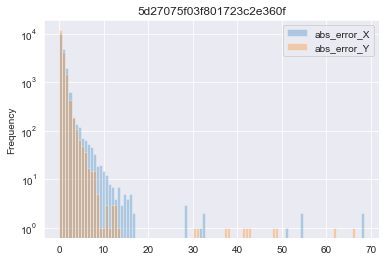

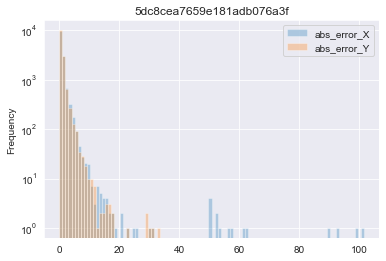

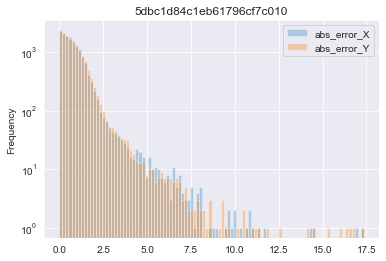

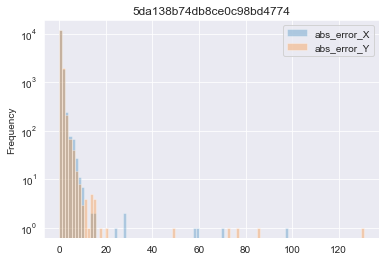

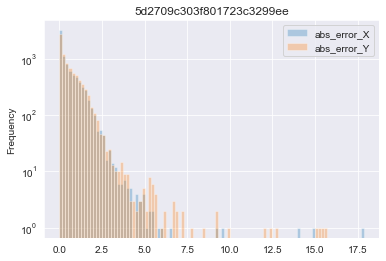

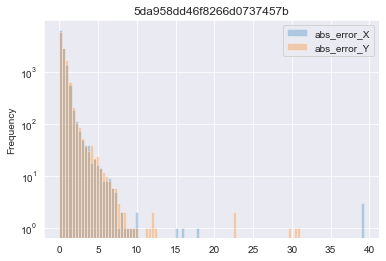

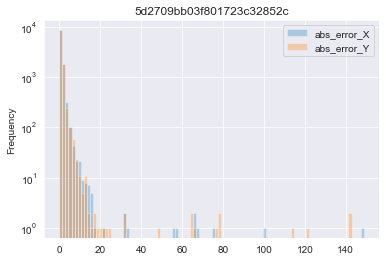

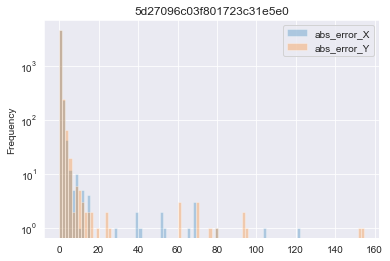

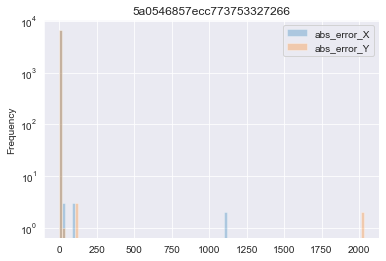

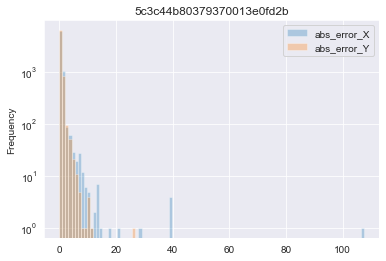

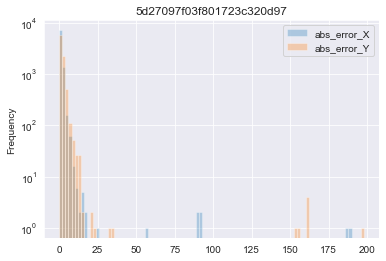

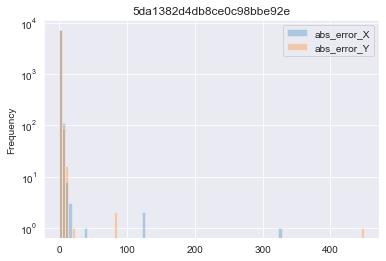

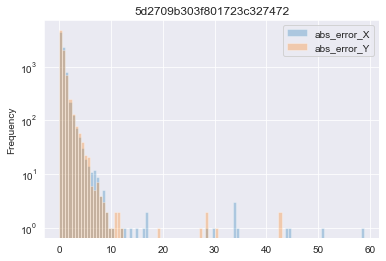

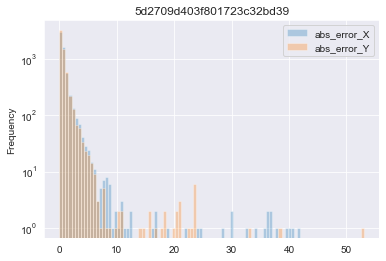

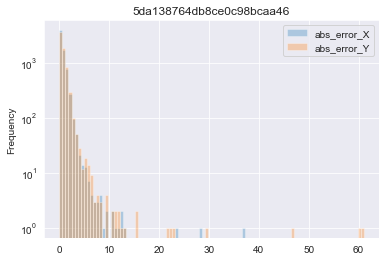

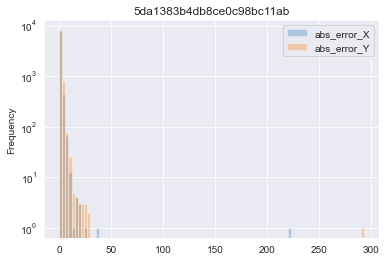

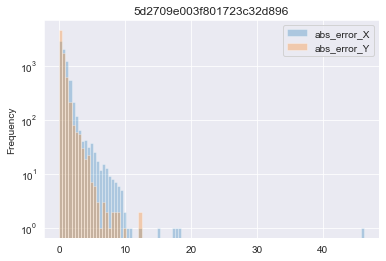

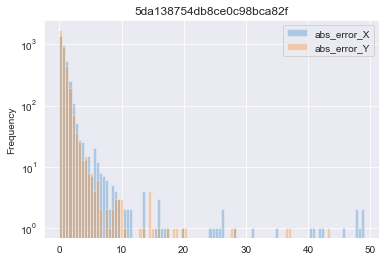

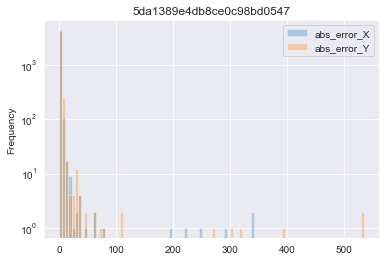

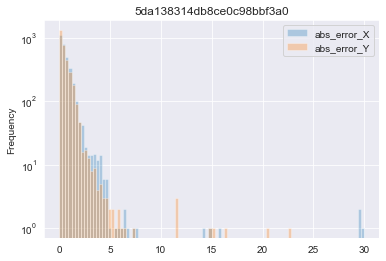

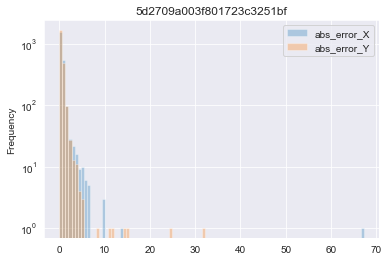

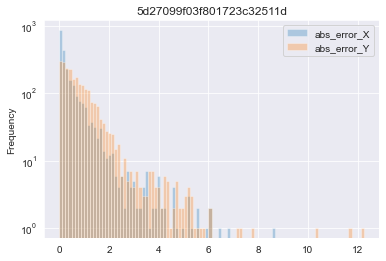

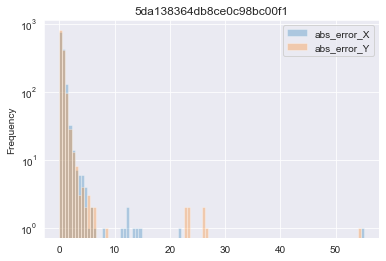

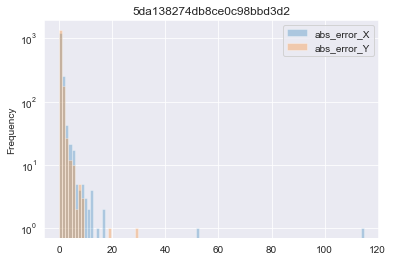

In [4]:
models24_xy = {}
train_val_comparison_xy = []
num_s = 0

site_ids_shapes = {"5d27075f03f801723c2e360f": (73141, 14063), "5dc8cea7659e181adb076a3f": (57849, 9733), "5dbc1d84c1eb61796cf7c010": (61727, 9043), "5da138b74db8ce0c98bd4774": (56668, 7075),
                   "5d2709c303f801723c3299ee": (33368, 11667), "5da958dd46f8266d0737457b": (47796, 7003), "5d2709bb03f801723c32852c": (44009, 4909), "5d27096c03f801723c31e5e0": (19337, 9933),
                   "5a0546857ecc773753327266": (26532, 6799), "5c3c44b80379370013e0fd2b": (29359, 6131), "5d27097f03f801723c320d97": (35121, 4985), "5da1382d4db8ce0c98bbe92e": (28975, 5729),
                   "5d2709b303f801723c327472": (32449, 3831), "5d2709d403f801723c32bd39": (23545, 4283), "5da138764db8ce0c98bcaa46": (27771, 3781), "5da1383b4db8ce0c98bc11ab": (34396, 3055),
                   "5d2709e003f801723c32d896": (29752, 2623), "5da138754db8ce0c98bca82f": (13795, 3259), "5da1389e4db8ce0c98bd0547": (17795, 2047), "5da138314db8ce0c98bbf3a0": (13122, 2429),
                   "5d2709a003f801723c3251bf": (9345, 2509), "5d27099f03f801723c32511d": (9700, 1855), "5da138364db8ce0c98bc00f1": (5555, 1649), "5da138274db8ce0c98bbd3d2": (6338, 985)}

site_ids_lrate = {"5d27075f03f801723c2e360f": 0.0, "5dc8cea7659e181adb076a3f": 0.0, "5dbc1d84c1eb61796cf7c010": 0.0, "5da138b74db8ce0c98bd4774": 0.0, 
                  "5d2709c303f801723c3299ee": 0.0, "5da958dd46f8266d0737457b": 0.0, "5d2709bb03f801723c32852c": 0.0, "5d27096c03f801723c31e5e0": 0.0, 
                  "5a0546857ecc773753327266": 0.002, "5c3c44b80379370013e0fd2b": 0.002, "5d27097f03f801723c320d97": 0.001, "5da1382d4db8ce0c98bbe92e": 0.002, 
                  "5d2709b303f801723c327472": 0.002, "5d2709d403f801723c32bd39": 0.002, "5da138764db8ce0c98bcaa46": 0.002, "5da1383b4db8ce0c98bc11ab": 0.001, 
                  "5d2709e003f801723c32d896": 0.002, "5da138754db8ce0c98bca82f": 0.004, "5da1389e4db8ce0c98bd0547": 0.003, "5da138314db8ce0c98bbf3a0": 0.004, 
                  "5d2709a003f801723c3251bf": 0.005, "5d27099f03f801723c32511d": 0.005, "5da138364db8ce0c98bc00f1": 0.009, "5da138274db8ce0c98bbd3d2": 0.008}

site_ids = ["5d2709d403f801723c32bd39"]

r_seeds = [123]#[1, 12, 123, 1234, 12345]

for r_seed in r_seeds:

    for site_id in site_ids_lrate.keys(): #site_ids:#site_ids_num_bddsid.keys(): #site_ids:
        num_s += 1
        print(f"Working on #{num_s}: Site-{site_id}")

        #========================================================================================       
        f_list, scaler_xy, encoder_xy, train_x, val_x, train_y_x, train_y_y, val_y_x, val_y_y = preprocess_data(load_data(site_id, 10000), target_type="XY",
                                                                                                                data_fraction=1, random_state=r_seed,
                                                                                                                delay_lim=4000, rssi_lim=-94)
        train_y_xy = np.stack([train_y_x, train_y_y], axis=1)
        val_y_xy = np.stack([val_y_x, val_y_y], axis=1)

        model_xy = DNN(site_id=site_id, target_type="XY",
                       train_x=train_x, val_x=val_x,
                       train_y=train_y_xy, val_y=val_y_xy,
                       w_f=0.1, drop=0.01, learning_rate=round(50/site_ids_shapes[site_id][0], 4), epochs=100, batch=0)


        models24_xy[site_id] = [f_list[5:], scaler_xy, encoder_xy, model_xy]

        #========================================================================================
        # sanity check section
        predict_columns = ["predict_X", "predict_Y"]
        real_columns = ["real_X", "real_Y"]
        col_dic = {0: "_X", 1: "_Y"}

        predictions_train_xy = pd.DataFrame(model_xy.predict(train_x), columns=predict_columns)
        comparison_train_xy = pd.concat([pd.DataFrame(train_y_xy, columns=real_columns),
                                      predictions_train_xy], axis=1)
        predictions_val_xy = pd.DataFrame(model_xy.predict(val_x), columns=predict_columns)
        comparison_val_xy = pd.concat([pd.DataFrame(val_y_xy, columns=real_columns),
                                    predictions_val_xy], axis=1)

        for col_i, col in enumerate(predict_columns):
            for train_valid in [comparison_train_xy, comparison_val_xy]:
                train_valid["abs_error"+col_dic[col_i]] = np.abs(train_valid[real_columns[col_i]] - train_valid[col])

        for train_valid in [comparison_train_xy, comparison_val_xy]:
            mean_error = np.sqrt(np.power(train_valid["abs_error_X"], 2) + np.power(train_valid["abs_error_Y"], 2))
            train_valid["mean_abs_error"] = mean_error.cumsum()/train_valid.shape[0]

        print(f"Predictions (train/validation) #{num_s}: Site-{site_id}")
        #display(comparison_train_xy[["mean_abs_error"]].tail(1))
        #display(comparison_val_xy[["mean_abs_error"]].tail(1))

        train_val_comparison_xy.append([comparison_train_xy, comparison_val_xy])
        #========================================================================================
        display(comparison_val_xy.describe())
        display(comparison_val_xy[(comparison_val_xy.abs_error_X > 20) | (comparison_val_xy.abs_error_Y > 20)])
        
        comparison_val_xy[["abs_error_X", "abs_error_Y"]].plot.hist(bins=100, logy=True, alpha=0.3, title=site_id)
        
        keras.backend.clear_session()
        #break
    print("Finished fitting")
    calculate_global_metrics(train_val_comparison_xy)
    save_models(models24_xy, "XY", f"models24_Fcat_XY_R{r_seed}")
    print("Finished Models Saving")
    #%tensorboard --logdir log/Neurals  # commandline to start tensorboard

***
FLOOR PREDICTION MODELS (without XY as features)
***

In [5]:
models24_f = {}
train_val_comparison_f = []
num_s = 0

site_ids_shapes = {"5d27075f03f801723c2e360f": (73141, 14063), "5dc8cea7659e181adb076a3f": (57849, 9733), "5dbc1d84c1eb61796cf7c010": (61727, 9043), "5da138b74db8ce0c98bd4774": (56668, 7075),
                   "5d2709c303f801723c3299ee": (33368, 11667), "5da958dd46f8266d0737457b": (47796, 7003), "5d2709bb03f801723c32852c": (44009, 4909), "5d27096c03f801723c31e5e0": (19337, 9933),
                   "5a0546857ecc773753327266": (26532, 6799), "5c3c44b80379370013e0fd2b": (29359, 6131), "5d27097f03f801723c320d97": (35121, 4985), "5da1382d4db8ce0c98bbe92e": (28975, 5729),
                   "5d2709b303f801723c327472": (32449, 3831), "5d2709d403f801723c32bd39": (23545, 4283), "5da138764db8ce0c98bcaa46": (27771, 3781), "5da1383b4db8ce0c98bc11ab": (34396, 3055),
                   "5d2709e003f801723c32d896": (29752, 2623), "5da138754db8ce0c98bca82f": (13795, 3259), "5da1389e4db8ce0c98bd0547": (17795, 2047), "5da138314db8ce0c98bbf3a0": (13122, 2429),
                   "5d2709a003f801723c3251bf": (9345, 2509), "5d27099f03f801723c32511d": (9700, 1855), "5da138364db8ce0c98bc00f1": (5555, 1649), "5da138274db8ce0c98bbd3d2": (6338, 985)}

site_ids_lrate = {"5d27075f03f801723c2e360f": 0.0, "5dc8cea7659e181adb076a3f": 0.0, "5dbc1d84c1eb61796cf7c010": 0.0, "5da138b74db8ce0c98bd4774": 0.0, 
                  "5d2709c303f801723c3299ee": 0.0, "5da958dd46f8266d0737457b": 0.0, "5d2709bb03f801723c32852c": 0.0, "5d27096c03f801723c31e5e0": 0.0, 
                  "5a0546857ecc773753327266": 0.002, "5c3c44b80379370013e0fd2b": 0.002, "5d27097f03f801723c320d97": 0.001, "5da1382d4db8ce0c98bbe92e": 0.002, 
                  "5d2709b303f801723c327472": 0.002, "5d2709d403f801723c32bd39": 0.002, "5da138764db8ce0c98bcaa46": 0.002, "5da1383b4db8ce0c98bc11ab": 0.001, 
                  "5d2709e003f801723c32d896": 0.002, "5da138754db8ce0c98bca82f": 0.004, "5da1389e4db8ce0c98bd0547": 0.003, "5da138314db8ce0c98bbf3a0": 0.004, 
                  "5d2709a003f801723c3251bf": 0.005, "5d27099f03f801723c32511d": 0.005, "5da138364db8ce0c98bc00f1": 0.009, "5da138274db8ce0c98bbd3d2": 0.008}

site_ids = ["5da1389e4db8ce0c98bd0547"]

r_seeds = [123]#[1, 12, 123, 1234, 12345]

for r_seed in r_seeds:
    for site_id in site_ids_shapes.keys(): #site_ids:
        num_s += 1
        print(f"Working on #{num_s}: Site-{site_id}")

        #========================================================================================       
        f_list, scaler_f, target_binarizer_f, train_x, val_x, train_y_f, val_y_f = preprocess_data(load_data(site_id, 10000), target_type="F0",
                                                                                                   data_fraction=1, random_state=r_seed,
                                                                                                   delay_lim=4000, rssi_lim=-94)
        model_f = DNN(site_id=site_id, target_type="F0",
                      train_x=train_x, val_x=val_x,
                      train_y=train_y_f, val_y=val_y_f,
                      w_f=0.1, drop=0.01, learning_rate=round(50/site_ids_shapes[site_id][0], 4), epochs=100, batch=0)

        models24_f[site_id] = [f_list[5:], scaler_f, target_binarizer_f, model_f]

        #========================================================================================
        # sanity check section
        predict_columns = ["predict_F"]
        real_columns = ["real_F"]
        col_dic = {0: "_F"}

        predictions_train_f = pd.DataFrame(target_binarizer_f.inverse_transform(model_f.predict(train_x)), columns=predict_columns)
        comparison_train_f = pd.concat([pd.DataFrame(target_binarizer_f.inverse_transform(train_y_f), columns=real_columns),
                                      predictions_train_f], axis=1)
        predictions_val_f = pd.DataFrame(target_binarizer_f.inverse_transform(model_f.predict(val_x)), columns=predict_columns)
        comparison_val_f = pd.concat([pd.DataFrame(target_binarizer_f.inverse_transform(val_y_f), columns=real_columns),
                                    predictions_val_f], axis=1)

        for col_i, col in enumerate(predict_columns):
            for train_valid in [comparison_train_f, comparison_val_f]:
                train_valid["abs_error"+col_dic[col_i]] = np.abs(train_valid[real_columns[col_i]] - train_valid[col])

        for train_valid in [comparison_train_f, comparison_val_f]:
            mean_error = 15*(train_valid["abs_error_F"])
            train_valid["mean_abs_error"] = mean_error.cumsum()/train_valid.shape[0]

            train_valid["accurate"] = np.array(train_valid["abs_error_F"] < 0.5).astype(int)
            train_valid["floor_accuracy"] = train_valid["accurate"].cumsum()/train_valid.shape[0]

        print(f"Predictions (train/validation) #{num_s}: Site-{site_id}")
        display(comparison_train_f[["mean_abs_error", "floor_accuracy"]].tail(1))
        display(comparison_val_f[["mean_abs_error", "floor_accuracy"]].tail(1))

        train_val_comparison_f.append([comparison_train_f, comparison_val_f])
        #========================================================================================
        display(comparison_val_f.describe())
        display(comparison_val_f[comparison_val_f.accurate < 1])

        keras.backend.clear_session()
        #break
    print("Finished fitting")
    calculate_global_metrics(train_val_comparison_f)
    save_models(models24_f, "F0", f"models24_Fcat_F0_R{r_seed}")
    print("Finished Models Saving")
#%tensorboard --logdir log/Neurals  # commandline to start tensorboard

Working on #1: Site-5d27075f03f801723c2e360f
Loading Data...
Processing Data of shape (73141, 14063) with target->F0...
Fitting F0-Model...
Predictions (train/validation) #1: Site-5d27075f03f801723c2e360f


,mean_abs_error,floor_accuracy
54854,0.000547,0.999964


,mean_abs_error,floor_accuracy
18285,0.001641,0.999891


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
count,18286.000000,18286.000000,18286.000000,18286.000000,18286.000000,18286.000000
mean,1.126764,1.126873,0.000109,0.000405,0.999891,0.500000
std,1.402879,1.402869,0.010458,0.000630,0.010458,0.288649
min,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000055
25%,0.000000,0.000000,0.000000,0.000000,1.000000,0.250041
50%,1.000000,1.000000,0.000000,0.000000,1.000000,0.500027
75%,2.000000,2.000000,0.000000,0.000820,1.000000,0.749959
max,6.000000,6.000000,1.000000,0.001641,1.000000,0.999891


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
12375,2,3,1,0.000820,0,0.676747
15174,-1,0,1,0.001641,0,0.829760


Working on #2: Site-5dc8cea7659e181adb076a3f
Loading Data...
Processing Data of shape (57849, 9733) with target->F0...
Fitting F0-Model...
Predictions (train/validation) #2: Site-5dc8cea7659e181adb076a3f


,mean_abs_error,floor_accuracy
43385,0.012446,0.99917


,mean_abs_error,floor_accuracy
14462,0.020743,0.998755


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
count,14463.000000,14463.000000,14463.000000,14463.000000,14463.000000,14463.000000
mean,2.351241,2.351933,0.001383,0.013801,0.998755,0.499221
std,2.031077,2.030617,0.040714,0.005555,0.035258,0.288357
min,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000069
25%,1.000000,1.000000,0.000000,0.009334,1.000000,0.249499
50%,2.000000,2.000000,0.000000,0.014520,1.000000,0.499205
75%,4.000000,4.000000,0.000000,0.018668,1.000000,0.748911
max,6.000000,6.000000,2.000000,0.020743,1.000000,0.998755


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
28,0,1,1,0.001037,0,0.001936
127,2,1,1,0.002074,0,0.008712
362,2,4,2,0.004149,0,0.024891
774,2,1,1,0.005186,0,0.053308
1561,0,1,1,0.006223,0,0.107654
1779,0,1,1,0.007260,0,0.122658
2409,0,1,1,0.008297,0,0.166148
3000,0,1,1,0.009334,0,0.206942
4003,0,1,1,0.010371,0,0.276222
5759,0,1,1,0.011408,0,0.397566


Working on #3: Site-5dbc1d84c1eb61796cf7c010
Loading Data...
Processing Data of shape (61727, 9043) with target->F0...
Fitting F0-Model...
Predictions (train/validation) #3: Site-5dbc1d84c1eb61796cf7c010


,mean_abs_error,floor_accuracy
46294,0.005832,0.999611


,mean_abs_error,floor_accuracy
15431,0.015552,0.999352


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
count,15432.000000,15432.000000,15432.000000,15432.000000,15432.000000,15432.000000
mean,3.500583,3.500583,0.001037,0.004464,0.999352,0.499765
std,2.365314,2.364766,0.050903,0.003374,0.025449,0.288517
min,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000065
25%,2.000000,2.000000,0.000000,0.001944,1.000000,0.249919
50%,4.000000,4.000000,0.000000,0.003888,1.000000,0.499773
75%,5.000000,5.000000,0.000000,0.006804,1.000000,0.749563
max,7.000000,7.000000,4.000000,0.015552,1.000000,0.999352


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
1886,1,2,1,0.000972,0,0.122214
3462,1,2,1,0.001944,0,0.224274
4514,1,2,1,0.002916,0,0.292379
5082,1,2,1,0.003888,0,0.329121
10382,1,2,1,0.004860,0,0.672499
10585,1,2,1,0.005832,0,0.685588
11184,1,2,1,0.006804,0,0.724339
13038,6,2,4,0.010692,0,0.844414
15108,1,2,1,0.011664,0,0.978486
15423,6,2,4,0.015552,0,0.998834


Working on #4: Site-5da138b74db8ce0c98bd4774
Loading Data...
Processing Data of shape (56668, 7075) with target->F0...
Fitting F0-Model...
Predictions (train/validation) #4: Site-5da138b74db8ce0c98bd4774


,mean_abs_error,floor_accuracy
42500,0.0,1.0


,mean_abs_error,floor_accuracy
14166,0.00847,0.999859


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
count,14167.000000,14167.000000,14167.000000,14167.000000,14167.000000,14167.000000
mean,1.074610,1.074045,0.000565,0.004732,0.999859,0.499956
std,1.928558,1.928287,0.047525,0.002763,0.011881,0.288644
min,-2.000000,-2.000000,0.000000,0.000000,0.000000,0.000071
25%,-1.000000,-1.000000,0.000000,0.004235,1.000000,0.249982
50%,1.000000,1.000000,0.000000,0.004235,1.000000,0.499965
75%,3.000000,3.000000,0.000000,0.008470,1.000000,0.749876
max,4.000000,4.000000,4.000000,0.008470,1.000000,0.999859


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
2282,4,0,4,0.004235,0,0.161079
10224,4,0,4,0.008470,0,0.721607


Working on #5: Site-5d2709c303f801723c3299ee
Loading Data...
Processing Data of shape (33368, 11667) with target->F0...
Fitting F0-Model...
Predictions (train/validation) #5: Site-5d2709c303f801723c3299ee


,mean_abs_error,floor_accuracy
25025,0.0,1.0


,mean_abs_error,floor_accuracy
8341,0.0,1.0


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
count,8342.000000,8342.000000,8342.0,8342.0,8342.0,8342.000000
mean,2.794294,2.794294,0.0,0.0,1.0,0.500060
std,2.238319,2.238319,0.0,0.0,0.0,0.288692
min,-1.000000,-1.000000,0.0,0.0,1.0,0.000120
25%,1.000000,1.000000,0.0,0.0,1.0,0.250090
50%,3.000000,3.000000,0.0,0.0,1.0,0.500060
75%,4.000000,4.000000,0.0,0.0,1.0,0.750030
max,8.000000,8.000000,0.0,0.0,1.0,1.000000


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy


Working on #6: Site-5da958dd46f8266d0737457b
Loading Data...
Processing Data of shape (47796, 7003) with target->F0...
Fitting F0-Model...
Predictions (train/validation) #6: Site-5da958dd46f8266d0737457b


,mean_abs_error,floor_accuracy
35846,0.0,1.0


,mean_abs_error,floor_accuracy
11948,0.003766,0.999749


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
count,11949.000000,11949.000000,11949.000000,11949.000000,11949.000000,11949.000000
mean,1.674199,1.673948,0.000251,0.001040,0.999749,0.499973
std,2.043441,2.043462,0.015844,0.001473,0.015844,0.288604
min,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000084
25%,0.000000,0.000000,0.000000,0.000000,1.000000,0.250063
50%,1.000000,1.000000,0.000000,0.000000,1.000000,0.500042
75%,3.000000,3.000000,0.000000,0.002511,1.000000,0.749854
max,6.000000,6.000000,1.000000,0.003766,1.000000,0.999749


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
7497,2,1,1,0.001255,0,0.627417
8435,2,1,1,0.002511,0,0.705833
10015,2,1,1,0.003766,0,0.837978


Working on #7: Site-5d2709bb03f801723c32852c
Loading Data...
Processing Data of shape (44009, 4909) with target->F0...
Fitting F0-Model...
Predictions (train/validation) #7: Site-5d2709bb03f801723c32852c


,mean_abs_error,floor_accuracy
33005,0.0,1.0


,mean_abs_error,floor_accuracy
11002,0.023175,0.999091


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
count,11003.000000,11003.000000,11003.000000,11003.000000,11003.000000,11003.000000
mean,0.715078,0.716077,0.001545,0.014294,0.999091,0.499508
std,1.136949,1.136120,0.054745,0.005650,0.030135,0.288485
min,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000091
25%,0.000000,0.000000,0.000000,0.014996,1.000000,0.249523
50%,1.000000,1.000000,0.000000,0.014996,1.000000,0.499500
75%,2.000000,2.000000,0.000000,0.017722,1.000000,0.749387
max,3.000000,3.000000,3.000000,0.023175,1.000000,0.999091


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
347,-1,1,2,0.002727,0,0.031537
780,-1,1,2,0.005453,0,0.070799
1551,0,1,1,0.006816,0,0.140780
1939,0,1,1,0.008180,0,0.175952
2077,-1,1,2,0.010906,0,0.188403
2614,3,0,3,0.014996,0,0.237117
8105,-1,1,2,0.017722,0,0.736072
8261,0,1,1,0.019086,0,0.750159
9033,0,1,1,0.020449,0,0.820231
10218,-1,1,2,0.023175,0,0.927838


Working on #8: Site-5d27096c03f801723c31e5e0
Loading Data...
Processing Data of shape (19337, 9933) with target->F0...
Fitting F0-Model...
Predictions (train/validation) #8: Site-5d27096c03f801723c31e5e0


,mean_abs_error,floor_accuracy
14501,0.131361,0.99607


,mean_abs_error,floor_accuracy
4834,0.220269,0.992968


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
count,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000
mean,1.996484,2.002482,0.014685,0.110092,0.992968,0.496887
std,1.937423,1.941318,0.209397,0.073701,0.083571,0.286611
min,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000207
25%,0.000000,0.000000,0.000000,0.034126,1.000000,0.248914
50%,2.000000,2.000000,0.000000,0.089969,1.000000,0.497622
75%,4.000000,4.000000,0.000000,0.195450,1.000000,0.744467
max,5.000000,5.000000,5.000000,0.220269,1.000000,0.992968


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
182,4,5,1,0.003102,0,0.037642
220,4,5,1,0.006205,0,0.045295
320,5,2,3,0.015512,0,0.065770
363,5,2,3,0.024819,0,0.074457
628,4,5,1,0.027921,0,0.129059
1086,1,3,2,0.034126,0,0.223578
1243,0,5,5,0.049638,0,0.255843
1401,4,5,1,0.052740,0,0.288314
1486,5,2,3,0.062048,0,0.305688
1957,0,5,5,0.077559,0,0.402896


Working on #9: Site-5a0546857ecc773753327266
Loading Data...
Processing Data of shape (26532, 6799) with target->F0...
Fitting F0-Model...
Predictions (train/validation) #9: Site-5a0546857ecc773753327266


,mean_abs_error,floor_accuracy
19898,0.0,1.0


,mean_abs_error,floor_accuracy
6632,0.013569,0.999397


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
count,6633.000000,6633.000000,6633.000000,6633.000000,6633.000000,6633.000000
mean,1.092266,1.092869,0.000905,0.006590,0.999397,0.499815
std,1.391510,1.391578,0.038820,0.005616,0.024551,0.288468
min,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000151
25%,0.000000,0.000000,0.000000,0.000000,1.000000,0.250113
50%,1.000000,1.000000,0.000000,0.009046,1.000000,0.499774
75%,2.000000,2.000000,0.000000,0.011307,1.000000,0.749585
max,3.000000,3.000000,2.000000,0.013569,1.000000,0.999397


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
2534,0,2,2,0.004523,0,0.382029
2875,0,2,2,0.009046,0,0.433288
4617,0,1,1,0.011307,0,0.695764
5034,0,-1,1,0.013569,0,0.758480


Working on #10: Site-5c3c44b80379370013e0fd2b
Loading Data...
Processing Data of shape (29359, 6131) with target->F0...
Fitting F0-Model...
Predictions (train/validation) #10: Site-5c3c44b80379370013e0fd2b


,mean_abs_error,floor_accuracy
22018,0.0,1.0


,mean_abs_error,floor_accuracy
7339,0.0,1.0


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
count,7340.000000,7340.000000,7340.0,7340.0,7340.0,7340.000000
mean,0.840054,0.840054,0.0,0.0,1.0,0.500068
std,1.411621,1.411621,0.0,0.0,0.0,0.288695
min,-1.000000,-1.000000,0.0,0.0,1.0,0.000136
25%,0.000000,0.000000,0.0,0.0,1.0,0.250102
50%,1.000000,1.000000,0.0,0.0,1.0,0.500068
75%,2.000000,2.000000,0.0,0.0,1.0,0.750034
max,4.000000,4.000000,0.0,0.0,1.0,1.000000


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy


Working on #11: Site-5d27097f03f801723c320d97
Loading Data...
Processing Data of shape (35121, 4985) with target->F0...
Fitting F0-Model...
Predictions (train/validation) #11: Site-5d27097f03f801723c320d97


,mean_abs_error,floor_accuracy
26339,0.0,1.0


,mean_abs_error,floor_accuracy
8780,0.039289,0.999203


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
count,8781.000000,8781.000000,8781.000000,8781.000000,8781.000000,8781.000000
mean,1.777474,1.777360,0.002619,0.009802,0.999203,0.499851
std,1.707387,1.705937,0.093611,0.012197,0.028225,0.288468
min,-2.000000,-2.000000,0.000000,0.000000,0.000000,0.000114
25%,1.000000,1.000000,0.000000,0.000000,1.000000,0.250085
50%,2.000000,2.000000,0.000000,0.005125,1.000000,0.499943
75%,3.000000,3.000000,0.000000,0.010249,1.000000,0.749801
max,4.000000,4.000000,4.000000,0.039289,1.000000,0.999203


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
3647,4,1,3,0.005125,0,0.415329
4953,4,1,3,0.010249,0,0.563945
6737,-1,3,4,0.017082,0,0.766997
6849,-2,1,3,0.022207,0,0.779638
7209,4,1,3,0.027332,0,0.820522
8026,4,1,3,0.032456,0,0.913449
8144,-1,3,4,0.039289,0,0.926774


Working on #12: Site-5da1382d4db8ce0c98bbe92e
Loading Data...
Processing Data of shape (28975, 5729) with target->F0...
Fitting F0-Model...
Predictions (train/validation) #12: Site-5da1382d4db8ce0c98bbe92e


,mean_abs_error,floor_accuracy
21730,0.0,1.0


,mean_abs_error,floor_accuracy
7243,0.008283,0.999586


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
count,7244.000000,7244.000000,7244.000000,7244.000000,7244.000000,7244.000000
mean,1.091524,1.090972,0.000552,0.003550,0.999586,0.499863
std,1.684747,1.685186,0.028776,0.002628,0.020348,0.288591
min,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000138
25%,0.000000,0.000000,0.000000,0.002071,1.000000,0.249965
50%,1.000000,1.000000,0.000000,0.002071,1.000000,0.499931
75%,3.000000,3.000000,0.000000,0.004141,1.000000,0.749758
max,4.000000,4.000000,2.000000,0.008283,1.000000,0.999586


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
347,0,-1,1,0.002071,0,0.047902
4886,0,-1,1,0.004141,0,0.674351
5662,1,-1,2,0.008283,0,0.781336


Working on #13: Site-5d2709b303f801723c327472
Loading Data...
Processing Data of shape (32449, 3831) with target->F0...
Fitting F0-Model...
Predictions (train/validation) #13: Site-5d2709b303f801723c327472


,mean_abs_error,floor_accuracy
24335,0.0,1.0


,mean_abs_error,floor_accuracy
8112,0.003698,0.999753


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
count,8113.000000,8113.000000,8113.000000,8113.000000,8113.000000,8113.000000
mean,1.112042,1.112289,0.000247,0.003031,0.999753,0.499860
std,1.242986,1.242666,0.015700,0.001218,0.015700,0.288632
min,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000123
25%,0.000000,0.000000,0.000000,0.001849,1.000000,0.249969
50%,1.000000,1.000000,0.000000,0.003698,1.000000,0.499815
75%,2.000000,2.000000,0.000000,0.003698,1.000000,0.749784
max,3.000000,3.000000,1.000000,0.003698,1.000000,0.999753


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
826,-1,0,1,0.001849,0,0.101812
2101,-1,0,1,0.003698,0,0.258844


Working on #14: Site-5d2709d403f801723c32bd39
Loading Data...
Processing Data of shape (23545, 4283) with target->F0...
Fitting F0-Model...
Predictions (train/validation) #14: Site-5d2709d403f801723c32bd39


,mean_abs_error,floor_accuracy
17657,0.0,1.0


,mean_abs_error,floor_accuracy
5886,0.022932,0.998811


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
count,5887.000000,5887.000000,5887.000000,5887.000000,5887.000000,5887.000000
mean,-0.029896,-0.028707,0.001529,0.013188,0.998811,0.499402
std,0.978076,0.978198,0.046971,0.007867,0.034465,0.288302
min,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000170
25%,-1.000000,-1.000000,0.000000,0.010192,1.000000,0.249618
50%,0.000000,0.000000,0.000000,0.012740,1.000000,0.499405
75%,1.000000,1.000000,0.000000,0.022932,1.000000,0.748853
max,2.000000,2.000000,2.000000,0.022932,1.000000,0.998811


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
934,-1,1,2,0.005096,0,0.158655
1172,-1,0,1,0.007644,0,0.198913
1467,0,1,1,0.010192,0,0.248853
1958,0,1,1,0.012740,0,0.332088
3856,0,1,1,0.015288,0,0.654323
4021,-1,1,2,0.020384,0,0.682181
4149,1,0,1,0.022932,0,0.703754


Working on #15: Site-5da138764db8ce0c98bcaa46
Loading Data...
Processing Data of shape (27771, 3781) with target->F0...
Fitting F0-Model...
Predictions (train/validation) #15: Site-5da138764db8ce0c98bcaa46


,mean_abs_error,floor_accuracy
20827,0.0,1.0


,mean_abs_error,floor_accuracy
6942,0.015123,0.99928


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
count,6943.000000,6943.000000,6943.000000,6943.000000,6943.000000,6943.000000
mean,0.880455,0.880311,0.001008,0.009400,0.999280,0.499617
std,1.400949,1.400577,0.039794,0.003748,0.026828,0.288504
min,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000144
25%,0.000000,0.000000,0.000000,0.008642,1.000000,0.249676
50%,1.000000,1.000000,0.000000,0.008642,1.000000,0.499640
75%,2.000000,2.000000,0.000000,0.010802,1.000000,0.749460
max,4.000000,4.000000,2.000000,0.015123,1.000000,0.999280


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
118,3,1,2,0.004321,0,0.016996
1402,0,1,1,0.006481,0,0.201786
1687,1,0,1,0.008642,0,0.242690
4075,1,0,1,0.010802,0,0.586490
5496,-1,1,2,0.015123,0,0.791013


Working on #16: Site-5da1383b4db8ce0c98bc11ab
Loading Data...
Processing Data of shape (34396, 3055) with target->F0...
Fitting F0-Model...
Predictions (train/validation) #16: Site-5da1383b4db8ce0c98bc11ab


,mean_abs_error,floor_accuracy
25796,0.0,1.0


,mean_abs_error,floor_accuracy
8598,0.0,1.0


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
count,8599.000000,8599.000000,8599.0,8599.0,8599.0,8599.000000
mean,0.868473,0.868473,0.0,0.0,1.0,0.500058
std,0.796030,0.796030,0.0,0.0,0.0,0.288692
min,0.000000,0.000000,0.0,0.0,1.0,0.000116
25%,0.000000,0.000000,0.0,0.0,1.0,0.250087
50%,1.000000,1.000000,0.0,0.0,1.0,0.500058
75%,2.000000,2.000000,0.0,0.0,1.0,0.750029
max,2.000000,2.000000,0.0,0.0,1.0,1.000000


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy


Working on #17: Site-5d2709e003f801723c32d896
Loading Data...
Processing Data of shape (29752, 2623) with target->F0...
Fitting F0-Model...
Predictions (train/validation) #17: Site-5d2709e003f801723c32d896


,mean_abs_error,floor_accuracy
22313,0.0,1.0


,mean_abs_error,floor_accuracy
7437,0.010083,0.999866


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
count,7438.000000,7438.000000,7438.000000,7438.000000,7438.000000,7438.000000
mean,1.247916,1.247244,0.000672,0.008732,0.999866,0.499951
std,1.702368,1.702268,0.057975,0.003436,0.011595,0.288668
min,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000134
25%,0.000000,0.000000,0.000000,0.010083,1.000000,0.249966
50%,1.000000,1.000000,0.000000,0.010083,1.000000,0.499933
75%,3.000000,3.000000,0.000000,0.010083,1.000000,0.749899
max,4.000000,4.000000,5.000000,0.010083,1.000000,0.999866


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
997,4,-1,5,0.010083,0,0.134041


Working on #18: Site-5da138754db8ce0c98bca82f
Loading Data...
Processing Data of shape (13795, 3259) with target->F0...
Fitting F0-Model...
Predictions (train/validation) #18: Site-5da138754db8ce0c98bca82f


,mean_abs_error,floor_accuracy
10345,0.0,1.0


,mean_abs_error,floor_accuracy
3448,0.008698,0.99942


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
count,3449.000000,3449.000000,3449.000000,3449.000000,3449.000000,3449.000000
mean,1.383589,1.384169,0.000580,0.003871,0.999420,0.499887
std,1.062096,1.062706,0.024077,0.002769,0.024077,0.288554
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000290
25%,0.000000,0.000000,0.000000,0.000000,1.000000,0.250217
50%,1.000000,1.000000,0.000000,0.004349,1.000000,0.499855
75%,2.000000,2.000000,0.000000,0.004349,1.000000,0.749783
max,3.000000,3.000000,1.000000,0.008698,1.000000,0.999420


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
909,2,3,1,0.004349,0,0.263555
2919,2,3,1,0.008698,0,0.846042


Working on #19: Site-5da1389e4db8ce0c98bd0547
Loading Data...
Processing Data of shape (17795, 2047) with target->F0...
Fitting F0-Model...
Predictions (train/validation) #19: Site-5da1389e4db8ce0c98bd0547


,mean_abs_error,floor_accuracy
13345,0.198936,0.995729


,mean_abs_error,floor_accuracy
4448,0.158463,0.995729


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
count,4449.000000,4449.000000,4449.000000,4449.000000,4449.000000,4449.000000
mean,0.934367,0.939987,0.010564,0.076854,0.995729,0.498275
std,1.668506,1.661764,0.187577,0.041431,0.065218,0.287570
min,-2.000000,-2.000000,0.000000,0.000000,0.000000,0.000225
25%,-1.000000,-1.000000,0.000000,0.057316,1.000000,0.249045
50%,1.000000,1.000000,0.000000,0.074174,1.000000,0.498539
75%,2.000000,2.000000,0.000000,0.111261,1.000000,0.747359
max,3.000000,3.000000,4.000000,0.158463,1.000000,0.995729


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
102,-2,2,4,0.013486,0,0.022927
737,-2,2,4,0.026972,0,0.165430
778,3,2,1,0.030344,0,0.174421
897,-2,2,4,0.043830,0,0.200944
996,-2,2,4,0.057316,0,0.222971
1395,-2,2,4,0.070802,0,0.312430
1419,3,2,1,0.074174,0,0.317599
2318,3,2,1,0.077546,0,0.519443
3015,3,2,1,0.080917,0,0.675882
3025,3,2,1,0.084289,0,0.677905


Working on #20: Site-5da138314db8ce0c98bbf3a0
Loading Data...
Processing Data of shape (13122, 2429) with target->F0...
Fitting F0-Model...
Predictions (train/validation) #20: Site-5da138314db8ce0c98bbf3a0


,mean_abs_error,floor_accuracy
9840,0.001524,0.999898


,mean_abs_error,floor_accuracy
3280,0.0,1.0


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
count,3281.000000,3281.000000,3281.0,3281.0,3281.0,3281.000000
mean,-0.255105,-0.255105,0.0,0.0,1.0,0.500152
std,1.320739,1.320739,0.0,0.0,0.0,0.288719
min,-2.000000,-2.000000,0.0,0.0,1.0,0.000305
25%,-1.000000,-1.000000,0.0,0.0,1.0,0.250229
50%,0.000000,0.000000,0.0,0.0,1.0,0.500152
75%,1.000000,1.000000,0.0,0.0,1.0,0.750076
max,2.000000,2.000000,0.0,0.0,1.0,1.000000


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy


Working on #21: Site-5d2709a003f801723c3251bf
Loading Data...
Processing Data of shape (9345, 2509) with target->F0...
Fitting F0-Model...
Predictions (train/validation) #21: Site-5d2709a003f801723c3251bf


,mean_abs_error,floor_accuracy
7007,0.0,1.0


,mean_abs_error,floor_accuracy
2336,0.0,1.0


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
count,2337.000000,2337.000000,2337.0,2337.0,2337.0,2337.000000
mean,1.104835,1.104835,0.0,0.0,1.0,0.500214
std,1.140648,1.140648,0.0,0.0,0.0,0.288737
min,0.000000,0.000000,0.0,0.0,1.0,0.000428
25%,0.000000,0.000000,0.0,0.0,1.0,0.250321
50%,1.000000,1.000000,0.0,0.0,1.0,0.500214
75%,2.000000,2.000000,0.0,0.0,1.0,0.750107
max,3.000000,3.000000,0.0,0.0,1.0,1.000000


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy


Working on #22: Site-5d27099f03f801723c32511d
Loading Data...
Processing Data of shape (9700, 1855) with target->F0...
Fitting F0-Model...
Predictions (train/validation) #22: Site-5d27099f03f801723c32511d


,mean_abs_error,floor_accuracy
7274,0.0,1.0


,mean_abs_error,floor_accuracy
2424,0.0,1.0


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
count,2425.000000,2425.000000,2425.0,2425.0,2425.0,2425.000000
mean,1.094845,1.094845,0.0,0.0,1.0,0.500206
std,1.133823,1.133823,0.0,0.0,0.0,0.288735
min,-1.000000,-1.000000,0.0,0.0,1.0,0.000412
25%,1.000000,1.000000,0.0,0.0,1.0,0.250309
50%,1.000000,1.000000,0.0,0.0,1.0,0.500206
75%,2.000000,2.000000,0.0,0.0,1.0,0.750103
max,3.000000,3.000000,0.0,0.0,1.0,1.000000


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy


Working on #23: Site-5da138364db8ce0c98bc00f1
Loading Data...
Processing Data of shape (5555, 1649) with target->F0...
Fitting F0-Model...
Predictions (train/validation) #23: Site-5da138364db8ce0c98bc00f1


,mean_abs_error,floor_accuracy
4165,0.0,1.0


,mean_abs_error,floor_accuracy
1388,0.0,1.0


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
count,1389.000000,1389.000000,1389.0,1389.0,1389.0,1389.000000
mean,0.802736,0.802736,0.0,0.0,1.0,0.500360
std,0.825542,0.825542,0.0,0.0,0.0,0.288779
min,0.000000,0.000000,0.0,0.0,1.0,0.000720
25%,0.000000,0.000000,0.0,0.0,1.0,0.250540
50%,1.000000,1.000000,0.0,0.0,1.0,0.500360
75%,2.000000,2.000000,0.0,0.0,1.0,0.750180
max,2.000000,2.000000,0.0,0.0,1.0,1.000000


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy


Working on #24: Site-5da138274db8ce0c98bbd3d2
Loading Data...
Processing Data of shape (6338, 985) with target->F0...
Fitting F0-Model...
Predictions (train/validation) #24: Site-5da138274db8ce0c98bbd3d2


,mean_abs_error,floor_accuracy
4752,0.01578,0.998948


,mean_abs_error,floor_accuracy
1584,0.037855,0.997476


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
count,1585.000000,1585.000000,1585.000000,1585.000000,1585.000000,1585.000000
mean,0.793060,0.794322,0.002524,0.019698,0.997476,0.499002
std,0.738602,0.740661,0.050188,0.017092,0.050188,0.287707
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000631
25%,0.000000,0.000000,0.000000,0.000000,1.000000,0.250473
50%,1.000000,1.000000,0.000000,0.028391,1.000000,0.498423
75%,1.000000,1.000000,0.000000,0.037855,1.000000,0.747634
max,2.000000,2.000000,1.000000,0.037855,1.000000,0.997476


,real_F,predict_F,abs_error_F,mean_abs_error,accurate,floor_accuracy
589,1,0,1,0.009464,0,0.371609
728,1,2,1,0.018927,0,0.458675
757,1,2,1,0.028391,0,0.476341
967,1,2,1,0.037855,0,0.608202


  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

Finished fitting
Global Train/Validation MAE: 0.015267767346637068/0.025483685576509124
Saving Models...
INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_F0_R123_1617965574/5d27075f03f801723c2e360f_F0\assets


  4%|███▍                                                                               | 1/24 [00:01<00:30,  1.32s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_F0_R123_1617965574/5dc8cea7659e181adb076a3f_F0\assets


  8%|██████▉                                                                            | 2/24 [00:02<00:24,  1.14s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_F0_R123_1617965574/5dbc1d84c1eb61796cf7c010_F0\assets


 12%|██████████▍                                                                        | 3/24 [00:03<00:22,  1.06s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_F0_R123_1617965574/5da138b74db8ce0c98bd4774_F0\assets


 17%|█████████████▊                                                                     | 4/24 [00:04<00:22,  1.14s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_F0_R123_1617965574/5d2709c303f801723c3299ee_F0\assets


 21%|█████████████████▎                                                                 | 5/24 [00:05<00:21,  1.13s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_F0_R123_1617965574/5da958dd46f8266d0737457b_F0\assets


 25%|████████████████████▊                                                              | 6/24 [00:06<00:19,  1.06s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_F0_R123_1617965574/5d2709bb03f801723c32852c_F0\assets


 29%|████████████████████████▏                                                          | 7/24 [00:07<00:16,  1.01it/s]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_F0_R123_1617965574/5d27096c03f801723c31e5e0_F0\assets


 33%|███████████████████████████▋                                                       | 8/24 [00:08<00:15,  1.00it/s]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_F0_R123_1617965574/5a0546857ecc773753327266_F0\assets


 38%|███████████████████████████████▏                                                   | 9/24 [00:09<00:16,  1.09s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_F0_R123_1617965574/5c3c44b80379370013e0fd2b_F0\assets


 42%|██████████████████████████████████▏                                               | 10/24 [00:10<00:14,  1.02s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_F0_R123_1617965574/5d27097f03f801723c320d97_F0\assets


 46%|█████████████████████████████████████▌                                            | 11/24 [00:11<00:12,  1.01it/s]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_F0_R123_1617965574/5da1382d4db8ce0c98bbe92e_F0\assets


 50%|█████████████████████████████████████████                                         | 12/24 [00:12<00:11,  1.05it/s]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_F0_R123_1617965574/5d2709b303f801723c327472_F0\assets


 54%|████████████████████████████████████████████▍                                     | 13/24 [00:13<00:11,  1.02s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_F0_R123_1617965574/5d2709d403f801723c32bd39_F0\assets


 58%|███████████████████████████████████████████████▊                                  | 14/24 [00:14<00:09,  1.03it/s]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_F0_R123_1617965574/5da138764db8ce0c98bcaa46_F0\assets


 62%|███████████████████████████████████████████████████▎                              | 15/24 [00:15<00:08,  1.08it/s]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_F0_R123_1617965574/5da1383b4db8ce0c98bc11ab_F0\assets


 67%|██████████████████████████████████████████████████████▋                           | 16/24 [00:16<00:07,  1.12it/s]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_F0_R123_1617965574/5d2709e003f801723c32d896_F0\assets


 71%|██████████████████████████████████████████████████████████                        | 17/24 [00:17<00:06,  1.01it/s]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_F0_R123_1617965574/5da138754db8ce0c98bca82f_F0\assets


 75%|█████████████████████████████████████████████████████████████▌                    | 18/24 [00:18<00:05,  1.06it/s]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_F0_R123_1617965574/5da1389e4db8ce0c98bd0547_F0\assets


 79%|████████████████████████████████████████████████████████████████▉                 | 19/24 [00:18<00:04,  1.11it/s]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_F0_R123_1617965574/5da138314db8ce0c98bbf3a0_F0\assets


 83%|████████████████████████████████████████████████████████████████████▎             | 20/24 [00:19<00:03,  1.14it/s]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_F0_R123_1617965574/5d2709a003f801723c3251bf_F0\assets


 88%|███████████████████████████████████████████████████████████████████████▊          | 21/24 [00:20<00:02,  1.17it/s]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_F0_R123_1617965574/5d27099f03f801723c32511d_F0\assets


 92%|███████████████████████████████████████████████████████████████████████████▏      | 22/24 [00:21<00:01,  1.07it/s]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_F0_R123_1617965574/5da138364db8ce0c98bc00f1_F0\assets


 96%|██████████████████████████████████████████████████████████████████████████████▌   | 23/24 [00:22<00:00,  1.11it/s]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_F0_R123_1617965574/5da138274db8ce0c98bbd3d2_F0\assets


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:23<00:00,  1.03it/s]

Finished Models Saving


***
XY PREDICTION MODELS (without floor feature)
***

Working on #1: Site-5d27075f03f801723c2e360f
Loading Data...
Processing Data of shape (73141, 14063) with target->XY0...
Fitting XY0-Model...
Predictions (train/validation) #1: Site-5d27075f03f801723c2e360f


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,18286.000000,18286.000000,18286.000000,18286.000000,18286.000000,18286.000000,18286.000000
mean,151.832449,111.054345,151.757812,110.947769,0.916704,0.741970,0.655626
std,71.958024,38.100942,72.042664,38.134964,2.227938,1.641965,0.381676
min,2.102641,11.917374,2.734759,11.915717,0.000067,0.000018,0.000067
25%,92.782370,84.836115,92.317541,84.675781,0.225316,0.198933,0.326831
50%,163.592790,109.152832,163.576691,108.767239,0.535705,0.461670,0.652953
75%,213.598943,134.568650,213.359772,134.551205,1.069085,0.920185,0.980843
max,288.561928,213.985361,299.944977,240.633499,126.349057,76.311015,1.325452


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
290,72.454600,54.746300,98.193146,71.734550,25.738546,16.988250,0.022004
1258,232.957658,113.162043,255.555695,144.159042,22.598037,30.996999,0.086920
4402,232.973858,113.537927,255.555695,144.159042,22.581836,30.621115,0.314186
5842,114.090502,126.775895,92.124863,118.574242,21.965639,8.201654,0.417202
6815,232.835048,112.698161,255.555695,144.159042,22.720647,31.460881,0.486608
7318,114.585660,127.001520,92.124863,118.574242,22.460797,8.427278,0.522379
7534,116.025363,86.092805,175.290329,132.673157,59.264966,46.580352,0.541066
9764,37.632846,114.621406,82.496162,187.480179,44.863316,72.858772,0.696889
10483,66.685486,15.949662,150.132172,75.215080,83.446686,59.265418,0.754199
10639,116.163610,85.738840,175.290329,132.673157,59.126719,46.934317,0.768085


Working on #2: Site-5dc8cea7659e181adb076a3f
Loading Data...
Processing Data of shape (57849, 9733) with target->XY0...
Fitting XY0-Model...
Predictions (train/validation) #2: Site-5dc8cea7659e181adb076a3f


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,14463.000000,14463.000000,14463.000000,14463.000000,14463.000000,14463.000000,14463.000000
mean,154.265950,107.596879,154.438156,108.046349,1.178707,1.066386,0.902722
std,63.726735,36.107612,63.737244,36.138412,3.680770,1.500473,0.507653
min,1.210977,1.148207,1.764329,1.756557,0.000225,0.000275,0.000024
25%,108.196255,79.567360,107.866249,80.019684,0.309709,0.357011,0.466668
50%,166.609820,108.016770,166.601715,108.206116,0.675014,0.722693,0.917217
75%,207.766680,131.172977,208.208977,131.842575,1.257718,1.291489,1.339279
max,266.828030,246.777212,266.617706,247.045822,105.771385,32.029907,1.757619


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
28,202.141700,114.255045,134.992050,94.524315,67.149650,19.730730,0.007600
127,158.835858,117.155016,134.992050,94.524315,23.843808,22.630701,0.019743
533,138.211550,129.146000,159.970139,138.068390,21.758589,8.922390,0.065754
774,159.221129,117.472124,134.992050,94.524315,24.229079,22.947809,0.094227
1040,39.957214,81.791801,134.992050,94.524315,95.034837,12.732513,0.130971
1159,181.865970,79.567360,134.992050,94.524315,46.873920,14.956955,0.148140
1389,114.063502,113.898909,134.992050,94.524315,20.928548,19.374594,0.173157
1473,39.855056,82.704450,134.992050,94.524315,95.136994,11.819865,0.186584
1561,210.625000,107.742195,134.992050,94.524315,75.632950,13.217880,0.202614
1683,184.907422,78.218444,134.992050,94.524315,49.915372,16.305871,0.220842


Working on #3: Site-5dbc1d84c1eb61796cf7c010
Loading Data...
Processing Data of shape (61727, 9043) with target->XY0...
Fitting XY0-Model...
Predictions (train/validation) #3: Site-5dbc1d84c1eb61796cf7c010


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,15432.000000,15432.000000,15432.000000,15432.000000,15432.000000,15432.000000,15432.000000
mean,122.367715,133.044859,122.398750,133.389114,0.923484,0.934165,0.718810
std,51.945877,60.464519,51.929482,60.513100,1.435386,1.014132,0.409102
min,15.694604,38.838123,15.438883,37.943268,0.000039,0.000017,0.000052
25%,79.155061,92.985818,79.122154,93.268860,0.309280,0.328826,0.367766
50%,125.836521,123.182191,125.751980,123.541504,0.665749,0.702676,0.720536
75%,164.493676,156.282828,164.558369,156.676926,1.158896,1.238488,1.069256
max,258.353431,350.069926,257.379852,349.971375,41.020919,16.827834,1.428398


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
55,72.363181,126.894661,92.682487,116.652687,20.319307,10.241974,0.006260
885,70.253314,122.296473,92.682487,116.652687,22.429173,5.643786,0.084022
1886,133.703407,106.831125,92.682487,116.652687,41.020919,9.821562,0.180781
2228,181.315668,52.368739,210.616943,61.585785,29.301275,9.217046,0.216474
2601,70.913632,119.994725,92.682487,116.652687,21.768855,3.342038,0.252556
2733,70.997359,124.645595,92.682487,116.652687,21.685128,7.992908,0.265661
2941,70.226330,123.022640,92.682487,116.652687,22.456157,6.369953,0.284754
3462,132.164718,105.031936,92.682487,116.652687,39.482231,11.620751,0.334858
4514,129.689268,103.190563,92.682487,116.652687,37.006781,13.462124,0.430308
4828,69.610967,121.780432,92.682487,116.652687,23.071521,5.127745,0.462411


Working on #4: Site-5da138b74db8ce0c98bd4774
Loading Data...
Processing Data of shape (56668, 7075) with target->XY0...
Fitting XY0-Model...
Predictions (train/validation) #4: Site-5da138b74db8ce0c98bd4774


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,14167.000000,14167.000000,14167.000000,14167.000000,14167.000000,14167.000000,14167.000000
mean,102.151856,123.963614,102.102386,123.907288,0.745805,0.792937,0.608038
std,39.293420,84.411670,39.340054,84.375221,1.705555,2.034880,0.347614
min,2.434888,2.058889,2.724549,1.899968,0.000038,0.000042,0.000109
25%,76.992766,69.790956,76.869156,69.804695,0.205011,0.230078,0.318247
50%,105.139291,104.102546,105.092537,104.005890,0.483559,0.541958,0.607128
75%,128.233882,152.502105,128.006165,152.453583,0.944335,1.020680,0.914783
max,214.130214,435.551800,306.716156,439.152344,103.357962,114.727611,1.206862


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
2282,56.498590,65.541630,159.856552,180.269241,103.357962,114.727611,0.203871
2840,13.298957,418.203500,63.781147,312.815979,50.482190,105.387521,0.256351
3178,128.653971,30.918179,125.256180,77.700340,3.397792,46.782161,0.285569
3251,18.874132,97.838545,38.598640,138.909958,19.724508,41.071413,0.294884
5523,86.815340,182.813800,123.856972,202.515793,37.041632,19.701993,0.482268
9001,157.157166,164.557610,228.837753,225.858475,71.680587,61.300865,0.770747
10224,213.861441,99.515796,306.716156,207.415253,92.854715,107.899457,0.880248
12779,108.495224,173.076970,154.509949,241.103622,46.014725,68.026652,1.092577


Working on #5: Site-5d2709c303f801723c3299ee
Loading Data...
Processing Data of shape (33368, 11667) with target->XY0...
Fitting XY0-Model...
Predictions (train/validation) #5: Site-5d2709c303f801723c3299ee


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,8342.000000,8342.000000,8342.000000,8342.000000,8342.000000,8342.000000,8342.000000
mean,36.375169,92.526700,36.325481,92.506981,0.608896,0.692410,0.549394
std,15.809421,64.681886,15.789268,64.623741,0.771596,0.920551,0.317677
min,1.450171,1.349328,1.087599,1.429637,0.000017,0.000117,0.000537
25%,23.382932,37.708698,23.292564,37.703671,0.099276,0.131730,0.276063
50%,36.967591,67.496279,37.011959,67.639946,0.335404,0.415520,0.542504
75%,48.121464,148.364517,48.077724,148.559502,0.916716,0.993720,0.824979
max,71.919014,218.940754,88.791100,218.571793,19.149650,25.546246,1.102370


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
4639,65.68544,43.64867,79.081429,69.194916,13.395989,25.546246,0.611376


Working on #6: Site-5da958dd46f8266d0737457b
Loading Data...
Processing Data of shape (47796, 7003) with target->XY0...
Fitting XY0-Model...
Predictions (train/validation) #6: Site-5da958dd46f8266d0737457b


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,11949.000000,11949.000000,11949.000000,11949.000000,11949.000000,11949.000000,11949.000000
mean,93.655346,126.971549,93.630219,127.224579,0.569993,0.681402,0.494719
std,29.771124,51.960769,29.762613,52.160431,1.242159,0.929523,0.290666
min,42.107366,5.030789,42.917858,4.831048,0.000033,0.000086,0.000246
25%,74.802839,89.103306,74.793961,89.398224,0.128058,0.207215,0.240169
50%,86.980280,128.955528,86.940132,129.185654,0.333349,0.468643,0.489603
75%,101.214573,159.546076,101.101776,159.890656,0.709061,0.858828,0.747629
max,229.268550,246.288470,233.447449,248.458878,61.654788,24.401445,1.003789


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
7497,71.171836,170.278639,132.657837,194.680084,61.486001,24.401445,0.622064
8435,71.003049,171.629931,132.657837,194.680084,61.654788,23.050153,0.704640
10015,71.118752,170.974158,132.657837,194.680084,61.539085,23.705926,0.837975


Working on #7: Site-5d2709bb03f801723c32852c
Loading Data...
Processing Data of shape (44009, 4909) with target->XY0...
Fitting XY0-Model...
Predictions (train/validation) #7: Site-5d2709bb03f801723c32852c


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,11003.000000,11003.000000,11003.000000,11003.000000,11003.000000,11003.000000,11003.000000
mean,165.842117,146.228520,165.799286,145.330414,1.162097,1.378230,0.999826
std,65.068817,69.286610,65.248871,68.865875,3.494389,3.400413,0.574638
min,7.890098,7.331297,7.916616,7.690567,0.000144,0.000424,0.000092
25%,127.541956,83.978954,126.163872,83.466759,0.381126,0.450650,0.525061
50%,173.582388,153.888920,173.803940,153.285263,0.785398,0.986432,1.007698
75%,212.068819,207.511009,212.191200,206.262627,1.381418,1.719603,1.492530
max,288.787800,283.763730,337.686218,334.771790,276.702551,237.212944,1.983392


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
93,263.945200,78.996799,292.554230,83.514481,28.609029,4.517682,0.017640
1551,178.402880,256.199160,266.370239,334.771790,87.967359,78.572630,0.275624
1939,191.977692,164.385488,249.606323,282.449249,57.628631,118.063762,0.349067
2077,205.358024,258.723028,178.821625,197.084442,26.536399,61.638586,0.381487
2614,60.983667,52.541512,337.686218,289.754456,276.702551,237.212944,0.499480
2717,208.554700,262.757900,187.065857,233.810242,21.488843,28.947658,0.519896
3285,16.373728,205.690500,17.582438,227.255646,1.208710,21.565146,0.618921
4117,263.702319,78.391483,292.554230,83.514481,28.851911,5.122998,0.761122
4118,158.189013,231.328547,203.222427,225.303864,45.033414,6.024683,0.765252
5695,158.732471,231.453114,203.222427,225.303864,44.489957,6.149251,1.044642


Working on #8: Site-5d27096c03f801723c31e5e0
Loading Data...
Processing Data of shape (19337, 9933) with target->XY0...
Fitting XY0-Model...
Predictions (train/validation) #8: Site-5d27096c03f801723c31e5e0


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000
mean,66.128256,77.454436,66.186348,77.811996,0.832547,0.956049,0.671322
std,18.000203,23.156582,18.379507,23.891346,3.762917,5.188407,0.412643
min,9.399940,19.978085,9.274636,21.617767,0.000098,0.000308,0.000083
25%,50.800867,59.734405,50.984316,59.902695,0.206294,0.222083,0.265820
50%,68.314501,78.435838,68.294785,78.412346,0.448368,0.482782,0.660388
75%,81.608176,95.024611,81.528534,95.494438,0.827175,0.830432,1.064837
max,99.790696,130.530210,180.110214,246.318848,109.805868,157.798261,1.350924


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
155,82.334670,111.180350,65.951256,77.986504,16.383414,33.193846,0.040956
272,55.257008,84.540614,84.104462,115.448784,28.847454,30.908170,0.076276
836,87.012770,74.369430,93.086433,95.258156,6.073663,20.888726,0.188061
838,65.156600,92.747400,82.745422,134.800751,17.588822,42.053351,0.197656
1225,84.348147,77.601779,142.224670,148.009949,57.876523,70.408170,0.286958
1401,69.318690,88.520587,179.124557,246.318848,109.805868,157.798261,0.363069
1680,64.918870,91.766044,119.551323,167.919312,54.632453,76.153268,0.443744
1786,65.477996,92.274342,119.551323,167.919312,54.073327,75.644970,0.481298
1820,65.189591,92.036750,119.551323,167.919312,54.361732,75.882561,0.506538
1964,79.917037,108.912823,158.907974,214.845627,78.990937,105.932804,0.561308


Working on #9: Site-5a0546857ecc773753327266
Loading Data...
Processing Data of shape (26532, 6799) with target->XY0...
Fitting XY0-Model...
Predictions (train/validation) #9: Site-5a0546857ecc773753327266


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,6633.000000,6633.000000,6633.000000,6633.000000,6633.000000,6633.000000,6633.000000
mean,95.478974,92.540121,95.391235,92.859238,0.731656,1.269046,0.907003
std,52.781998,40.408700,52.673832,52.067776,2.818819,32.492952,0.582042
min,5.856011,8.270370,5.956303,8.218225,0.000024,0.000117,0.000613
25%,49.589737,58.053326,49.383808,57.896301,0.195608,0.207658,0.283471
50%,90.058111,96.776836,90.178833,96.499985,0.454287,0.446201,1.151607
75%,137.148101,115.705223,136.755325,115.342682,0.856184,0.830673,1.429056
max,233.908621,193.173841,234.226944,1979.255859,108.045677,1867.163369,1.686019


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
1103,40.470850,182.913707,48.626392,284.383392,8.155542,101.469685,0.181754
1111,40.931930,182.038320,48.626392,284.383392,7.694462,102.345072,0.198298
2084,41.489588,181.108799,48.626392,284.383392,7.136804,103.274594,0.363674
2126,120.853628,156.103254,84.545319,141.575485,36.308309,14.527769,0.375157
2230,223.307817,160.074650,116.239937,132.644150,107.067880,27.430500,0.406660
2534,107.482590,112.092490,186.934647,1979.255859,79.452057,1867.163369,0.735687
2875,107.036224,112.325151,186.934647,1979.255859,79.898423,1866.930708,1.070608
3267,223.819291,160.330495,116.239937,132.644150,107.579354,27.686345,1.144205
4367,224.285614,160.477946,116.239937,132.644150,108.045677,27.833796,1.336708


Working on #10: Site-5c3c44b80379370013e0fd2b
Loading Data...
Processing Data of shape (29359, 6131) with target->XY0...
Fitting XY0-Model...
Predictions (train/validation) #10: Site-5c3c44b80379370013e0fd2b


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000
mean,227.956083,97.650045,227.873840,97.626106,0.786718,0.614330,0.549267
std,55.139126,37.468681,55.119232,37.440720,1.571963,0.689410,0.311178
min,97.289650,8.132080,97.506111,7.670959,0.000024,0.000156,0.000105
25%,183.705974,67.991004,183.598206,68.043802,0.247703,0.202969,0.283799
50%,227.236801,102.033170,227.060516,102.011971,0.539029,0.464849,0.545906
75%,270.985365,128.144701,271.029953,128.228207,0.918170,0.837083,0.818854
max,354.770260,176.210452,359.231262,175.778503,52.476382,10.418490,1.083023


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
294,237.796420,73.014540,197.850937,63.399178,39.945483,9.615362,0.048518
313,237.701879,73.242295,197.850937,63.399178,39.850942,9.843118,0.055468
2708,306.754880,165.775250,359.231262,161.053864,52.476382,4.721386,0.413665
4110,237.512018,73.817667,197.850937,63.399178,39.661081,10.418490,0.615877
4146,237.628669,73.536842,197.850937,63.399178,39.777732,10.137665,0.627575
5490,329.190700,128.225420,303.230927,120.659187,25.959773,7.566233,0.817347


Working on #11: Site-5d27097f03f801723c320d97
Loading Data...
Processing Data of shape (35121, 4985) with target->XY0...
Fitting XY0-Model...
Predictions (train/validation) #11: Site-5d27097f03f801723c320d97


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,8781.000000,8781.000000,8781.000000,8781.000000,8781.000000,8781.000000,8781.000000
mean,102.328747,162.654328,101.724640,162.156387,1.525289,1.666292,1.201912
std,44.920457,79.616571,44.636372,79.667084,3.720723,4.693703,0.720301
min,1.489235,7.098485,0.489943,7.069458,0.000571,0.000123,0.000087
25%,67.487661,97.662602,67.469833,96.545998,0.527106,0.521400,0.574403
50%,108.134875,165.792378,107.329468,165.852402,1.136642,1.133746,1.188711
75%,133.570876,228.064137,132.543549,227.843491,1.951189,1.997643,1.795078
max,215.606410,311.800957,301.845825,371.244812,135.267560,171.193803,2.488885


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
1841,19.214380,294.661960,20.887054,267.816254,1.672675,26.845706,0.480804
3047,96.926089,137.616948,118.516068,158.759506,21.589979,21.142558,0.797721
3186,60.222867,238.602788,55.812252,216.916245,4.410615,21.686543,0.837972
3647,110.484218,200.826946,243.118423,353.523071,132.634206,152.696126,0.983582
3789,65.630135,194.227300,72.410645,218.580307,6.780510,24.353007,1.023885
3862,69.323704,232.567861,80.643066,255.944504,11.319362,23.376642,1.045775
4488,96.631494,137.052387,118.516068,158.759506,21.884574,21.707120,1.218920
4953,110.387537,200.323418,245.594742,371.244812,135.207204,170.921394,1.365572
5770,97.395341,138.018991,118.516068,158.759506,21.120727,20.740516,1.582118
6737,172.555653,64.541206,301.845825,212.341614,129.290172,147.800408,1.855883


Working on #12: Site-5da1382d4db8ce0c98bbe92e
Loading Data...
Processing Data of shape (28975, 5729) with target->XY0...
Fitting XY0-Model...
Predictions (train/validation) #12: Site-5da1382d4db8ce0c98bbe92e


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,7244.000000,7244.000000,7244.000000,7244.000000,7244.000000,7244.000000,7244.000000
mean,118.099377,104.966081,118.425056,105.094795,1.488053,1.260447,1.051292
std,36.037854,37.631767,35.676010,37.803654,5.407769,4.559198,0.612153
min,5.330156,16.445168,4.347232,16.333275,0.000137,0.000008,0.000296
25%,93.605145,78.361385,94.444878,78.856712,0.535841,0.400654,0.541569
50%,118.703551,115.525747,118.914795,115.533699,1.126586,0.868789,1.025653
75%,147.438635,133.866375,147.389606,133.606945,1.899660,1.573103,1.556991
max,187.473410,181.582001,463.918243,428.226288,418.713610,322.181151,2.134983


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
347,150.137993,144.535345,241.874634,221.959549,91.736641,77.424204,0.111440
1353,42.472942,106.555330,109.830490,222.384888,67.357548,115.829558,0.409609
1384,47.860836,117.598076,91.974480,137.971344,44.113644,20.373268,0.424896
4886,149.781631,144.900510,241.874634,221.959549,92.093002,77.059039,1.388365
5028,42.951884,106.584750,109.830490,222.384888,66.878606,115.800137,1.448455
5662,45.204633,106.045137,463.918243,428.226288,418.713610,322.181151,1.692578
6406,177.216000,105.575180,197.382370,106.197678,20.166370,0.622498,1.897015


Working on #13: Site-5d2709b303f801723c327472
Loading Data...
Processing Data of shape (32449, 3831) with target->XY0...
Fitting XY0-Model...
Predictions (train/validation) #13: Site-5d2709b303f801723c327472


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,8113.000000,8113.000000,8113.000000,8113.000000,8113.000000,8113.000000,8113.000000
mean,130.328471,82.699178,130.204956,82.714233,0.804553,0.738331,0.609553
std,63.435288,22.834616,63.340195,22.763437,1.898297,1.313804,0.348035
min,13.599587,12.642829,13.745199,12.208331,0.000169,0.000001,0.000079
25%,68.955299,68.586966,68.798256,68.687439,0.210548,0.196762,0.312516
50%,125.908746,85.205075,126.236122,85.472069,0.490290,0.462690,0.620415
75%,195.197685,98.221976,194.624084,98.035896,0.924723,0.893556,0.907604
max,227.053981,143.911769,259.425659,159.463470,63.379540,41.435982,1.216365


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
826,105.339180,63.601785,168.718719,94.238525,63.379540,30.636741,0.129274
1932,40.974335,39.959152,89.191566,81.395134,48.217231,41.435982,0.295362
2101,105.386390,63.050090,168.718719,94.238525,63.332329,31.188435,0.330009
3274,57.468670,114.076240,118.730659,116.853638,61.261989,2.777398,0.501248
3582,217.683990,123.818040,196.670441,111.317955,21.013549,12.500085,0.554376
5528,40.475308,40.076147,89.191566,81.395134,48.716259,41.318987,0.829827
6750,221.140758,129.996668,259.425659,159.463470,38.284901,29.466803,1.012590
6785,25.427933,48.910397,51.151218,64.481941,25.723285,15.571544,1.020494
7993,165.625558,138.334580,193.991714,142.465317,28.366156,4.130737,1.191975
8042,221.726207,130.117503,259.425659,159.463470,37.699452,29.345967,1.206336


Working on #14: Site-5d2709d403f801723c32bd39
Loading Data...
Processing Data of shape (23545, 4283) with target->XY0...
Fitting XY0-Model...
Predictions (train/validation) #14: Site-5d2709d403f801723c32bd39


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,5887.000000,5887.000000,5887.000000,5887.000000,5887.000000,5887.000000,5887.000000
mean,84.151405,73.024407,84.721725,73.390060,1.119798,0.931568,0.790792
std,35.649056,31.645098,35.809753,31.645452,2.210554,1.787586,0.468899
min,12.289261,0.363219,12.866067,1.057793,0.000348,0.000024,0.000315
25%,57.541379,47.865645,57.792780,48.279825,0.331091,0.267342,0.379183
50%,82.861143,75.067390,83.343056,75.483002,0.702457,0.578431,0.799740
75%,103.532308,97.249891,104.159657,97.367821,1.295275,1.063295,1.199521
max,180.966510,144.558485,182.760620,150.326248,41.121094,45.315178,1.596750


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
294,109.284625,9.613535,143.359406,13.248485,34.074780,3.634949,0.069861
1048,41.591191,53.571729,78.101784,74.377167,36.510593,20.805438,0.262923
1172,63.344384,26.351143,94.025948,41.994873,30.681563,15.643730,0.294741
1241,110.245170,93.661520,130.951721,106.619858,20.706551,12.958338,0.319482
1352,107.021611,94.343376,78.101784,74.377167,28.919827,19.966209,0.351157
1593,110.511825,93.803123,130.951721,106.619858,20.439897,12.816734,0.414356
1600,106.024151,130.052673,133.224701,150.227249,27.200550,20.174576,0.420847
1935,76.910645,116.058624,56.047607,79.896400,20.863038,36.162224,0.513070
1958,80.386305,114.140195,101.380394,146.159424,20.994089,32.019229,0.525741
2535,41.689465,50.158280,78.101784,74.377167,36.412319,24.218887,0.675820


Working on #15: Site-5da138764db8ce0c98bcaa46
Loading Data...
Processing Data of shape (27771, 3781) with target->XY0...
Fitting XY0-Model...
Predictions (train/validation) #15: Site-5da138764db8ce0c98bcaa46


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,6943.000000,6943.000000,6943.000000,6943.000000,6943.000000,6943.000000,6943.000000
mean,67.464402,109.672294,67.466202,109.670639,0.913599,1.116230,0.810161
std,36.908427,43.924594,36.771935,43.753136,1.064012,1.518874,0.468524
min,2.863031,1.584540,3.490936,1.182943,0.000157,0.000092,0.000098
25%,35.443626,79.749131,35.109873,80.142647,0.301912,0.365334,0.415989
50%,65.813886,113.435537,65.994705,113.514374,0.665673,0.777127,0.808472
75%,101.296336,138.427938,101.274719,138.686371,1.207628,1.418002,1.216303
max,145.193014,209.861250,144.172897,213.624496,26.731062,36.792623,1.617747


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
1402,108.149970,95.083700,108.663918,125.854668,0.513948,30.770968,0.326473
1687,140.780400,6.356708,119.189430,43.149330,21.590970,36.792623,0.402867
2814,11.915385,159.957338,10.716769,137.874374,1.198615,22.082964,0.657957
3166,28.772820,103.699910,40.732971,124.862099,11.960151,21.162189,0.743280
4075,140.689672,7.130391,119.189430,43.149330,21.500242,36.018939,0.947106
4230,107.132788,42.527321,80.401726,55.732853,26.731062,13.205532,0.985383
5496,121.179680,131.422130,131.673203,157.762970,10.493523,26.340840,1.287293
6064,28.754434,103.247384,40.732971,124.862099,11.978537,21.614715,1.421984


Working on #16: Site-5da1383b4db8ce0c98bc11ab
Loading Data...
Processing Data of shape (34396, 3055) with target->XY0...
Fitting XY0-Model...
Predictions (train/validation) #16: Site-5da1383b4db8ce0c98bc11ab


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,8599.000000,8599.000000,8599.000000,8599.000000,8599.000000,8599.000000,8599.000000
mean,129.439914,180.350105,129.268494,181.340607,1.034249,1.550045,1.018744
std,55.936896,44.291297,55.655098,44.622452,2.761006,3.319136,0.585693
min,10.879340,91.184509,10.412510,84.617622,0.000381,0.000095,0.000212
25%,83.811926,149.016033,84.153744,149.723793,0.343533,0.577851,0.515456
50%,127.572230,186.080079,127.273079,186.694672,0.725259,1.184677,0.998664
75%,171.717118,218.180393,171.073418,219.221786,1.296804,1.991854,1.533450
max,274.223850,262.633519,275.896484,365.765656,231.675318,266.549963,2.029675


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
66,71.566639,207.659608,89.103271,249.793930,17.536633,42.134322,0.023912
535,118.277756,256.127043,142.218216,200.583008,23.940459,55.544035,0.132708
848,31.414787,156.244541,53.118919,181.380341,21.704133,25.135800,0.210753
1171,69.648208,201.907501,72.993851,226.432770,3.345642,24.525269,0.292562
1241,68.677150,202.819340,72.993851,226.432770,4.316701,23.613430,0.312281
3193,69.125825,202.388642,72.993851,226.432770,3.868026,24.044128,0.753538
4960,15.459234,99.215692,247.134552,365.765656,231.675318,266.549963,1.186831
6103,31.493007,156.838167,53.118919,181.380341,21.625913,24.542173,1.450785
6200,83.496008,100.900024,94.960815,122.229454,11.464807,21.329430,1.476793
6737,55.689006,199.868612,45.299538,179.480316,10.389468,20.388296,1.602057


Working on #17: Site-5d2709e003f801723c32d896
Loading Data...
Processing Data of shape (29752, 2623) with target->XY0...
Fitting XY0-Model...
Predictions (train/validation) #17: Site-5d2709e003f801723c32d896


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,7438.000000,7438.000000,7438.000000,7438.000000,7438.000000,7438.000000,7438.000000
mean,148.174469,46.586389,148.151077,46.538982,0.808595,0.514500,0.526871
std,67.409045,14.476018,67.359459,14.423397,1.313974,0.780258,0.311777
min,26.490181,7.981223,26.565948,7.900430,0.000328,0.000076,0.000117
25%,94.042788,35.546727,94.216322,35.511978,0.202854,0.115893,0.254181
50%,139.065787,45.101763,139.056129,45.055523,0.534033,0.300928,0.526435
75%,204.569923,57.861513,204.464043,57.782240,0.947156,0.646998,0.794818
max,279.116830,93.251680,278.350037,92.030762,34.389050,27.547092,1.071361


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
997,158.390145,53.157880,179.298676,80.704971,20.908530,27.547092,0.135325
2953,137.953282,39.117291,171.586014,39.490692,33.632732,0.373401,0.412987
3803,137.578153,38.669901,171.586014,39.490692,34.007861,0.820791,0.541886
5271,137.196964,38.298771,171.586014,39.490692,34.389050,1.191921,0.751363


Working on #18: Site-5da138754db8ce0c98bca82f
Loading Data...
Processing Data of shape (13795, 3259) with target->XY0...
Fitting XY0-Model...
Predictions (train/validation) #18: Site-5da138754db8ce0c98bca82f


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,3449.000000,3449.000000,3449.000000,3449.000000,3449.000000,3449.000000,3449.000000
mean,174.923614,54.452448,174.786743,54.412197,1.228263,0.836949,0.857661
std,58.203872,17.099752,58.027950,17.002071,3.604921,1.837751,0.469972
min,58.158095,15.379176,57.825733,15.895862,0.000776,0.000285,0.000495
25%,121.497032,41.795467,121.607857,41.766685,0.266612,0.227678,0.451711
50%,188.131030,50.174341,187.549026,50.159462,0.613584,0.496943,0.877003
75%,224.582722,64.191100,224.413071,64.296181,1.153630,0.938601,1.246777
max,282.335153,106.908360,297.195862,111.492424,72.693082,46.541674,1.629673


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
68,264.131777,46.217507,212.686813,36.263084,51.444964,9.954423,0.046695
182,264.623721,46.600169,212.686813,36.263084,51.936908,10.337085,0.117689
293,204.082670,80.101074,257.691589,103.291756,53.608919,23.190682,0.175351
309,106.680474,52.727916,73.102951,28.371187,33.577523,24.356729,0.191963
472,210.804550,59.292750,172.426224,46.537151,38.378326,12.755599,0.269072
527,203.641027,80.669110,257.691589,103.291756,54.050563,22.622645,0.309776
825,202.939428,84.524902,171.277115,72.122398,31.662313,12.402504,0.432386
909,76.581726,97.716490,104.966309,51.648224,28.384583,46.068266,0.481775
992,257.569700,34.823856,225.584686,32.898315,31.985014,1.925541,0.520066
1148,265.088978,46.866945,212.686813,36.263084,52.402165,10.603861,0.587395


Working on #19: Site-5da1389e4db8ce0c98bd0547
Loading Data...
Processing Data of shape (17795, 2047) with target->XY0...
Fitting XY0-Model...
Predictions (train/validation) #19: Site-5da1389e4db8ce0c98bd0547


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,4449.000000,4449.000000,4449.000000,4449.000000,4449.000000,4449.000000,4449.000000
mean,52.754602,57.740517,53.524811,58.078358,2.689450,2.302405,1.945078
std,51.543437,28.981615,52.591507,29.924339,11.997229,10.035094,1.130399
min,0.351751,2.018570,0.462354,1.323842,0.000911,0.000495,0.000378
25%,19.385367,32.759426,19.575621,33.262920,0.553208,0.567801,0.958384
50%,39.559572,60.726967,39.036045,62.001957,1.232347,1.218812,1.928894
75%,62.493542,81.977726,63.247181,82.207474,2.248905,2.342165,2.942255
max,216.138800,125.103470,375.322632,338.942474,300.182362,293.537296,3.915548


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
49,29.452335,29.056510,298.713318,278.127441,269.260983,249.070931,0.110639
102,208.385862,106.680901,96.321976,82.874008,112.063886,23.806893,0.168527
350,22.395834,80.009189,96.321976,82.874008,73.926141,2.864819,0.332321
358,53.777489,9.112417,96.321976,82.874008,42.544486,73.761592,0.356592
554,39.404658,16.890995,96.321976,82.874008,56.917318,65.983014,0.492535
708,72.934447,81.099582,96.321976,82.874008,23.387529,1.774427,0.578701
737,209.472471,84.678618,96.321976,82.874008,113.150495,1.804610,0.617746
778,69.502844,44.853896,134.916260,121.843124,65.413416,76.989229,0.660791
897,213.001364,123.267159,96.321976,82.874008,116.679388,40.393150,0.752016
990,24.797402,29.386149,96.321976,82.874008,71.524574,53.487859,0.825899


Working on #20: Site-5da138314db8ce0c98bbf3a0
Loading Data...
Processing Data of shape (13122, 2429) with target->XY0...
Fitting XY0-Model...
Predictions (train/validation) #20: Site-5da138314db8ce0c98bbf3a0


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,3281.000000,3281.000000,3281.000000,3281.000000,3281.000000,3281.000000,3281.000000
mean,54.852081,50.444025,54.724766,50.696297,0.723670,0.677164,0.569952
std,28.460038,22.647272,28.360609,22.757532,1.550072,1.258701,0.320491
min,2.076916,4.114502,1.985504,4.347466,0.000362,0.000533,0.000130
25%,28.533515,31.125904,28.723051,31.102993,0.187327,0.201792,0.294710
50%,47.511951,54.377914,47.455273,54.399044,0.453235,0.445053,0.556066
75%,78.285524,68.427746,77.999954,68.575500,0.868464,0.859360,0.854064
max,133.835633,107.527800,159.873764,108.382629,38.662394,33.278065,1.121454


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
136,121.211370,78.621180,159.873764,108.382629,38.662394,29.761449,0.062850
231,14.308986,76.451095,42.687943,70.771370,28.378956,5.679725,0.100270
364,14.982320,76.444120,42.687943,70.771370,27.705623,5.672750,0.154202
1373,82.065083,25.002648,92.564636,54.780342,10.499553,29.777694,0.474836
1735,121.628479,78.892723,159.873764,108.382629,38.245285,29.489906,0.602724
1962,13.553366,76.448627,42.687943,70.771370,29.134576,5.677257,0.687865
2374,46.262127,70.869876,66.583488,104.147942,20.321361,33.278065,0.828273


Working on #21: Site-5d2709a003f801723c3251bf
Loading Data...
Processing Data of shape (9345, 2509) with target->XY0...
Fitting XY0-Model...
Predictions (train/validation) #21: Site-5d2709a003f801723c3251bf


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,2337.000000,2337.000000,2337.000000,2337.000000,2337.000000,2337.000000,2337.000000
mean,69.029429,50.630160,69.359413,50.363483,0.768559,0.690422,0.577492
std,43.604442,16.960143,43.771961,16.820034,0.961795,0.860012,0.336673
min,9.642409,3.693623,10.142845,3.399380,0.000131,0.000143,0.000194
25%,32.873589,37.540972,33.327377,37.403782,0.244885,0.239585,0.285672
50%,56.382360,47.393275,56.707253,47.199436,0.535622,0.496538,0.570497
75%,103.927847,66.029419,104.560257,65.614143,0.972917,0.890196,0.871992
max,171.575003,88.685130,171.819489,87.555382,18.187403,20.659812,1.150613


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
1646,108.4773,34.60003,126.664703,55.259842,18.187403,20.659812,0.82536


Working on #22: Site-5d27099f03f801723c32511d
Loading Data...


C:\Users\Zhi\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:328: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



Processing Data of shape (9700, 1855) with target->XY0...
Fitting XY0-Model...
Predictions (train/validation) #22: Site-5d27099f03f801723c32511d


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,2425.000000,2425.000000,2425.000000,2425.000000,2425.000000,2425.000000,2425.000000
mean,18.262913,66.005131,18.355206,66.143669,0.515584,0.858391,0.567583
std,6.361459,30.957247,6.242099,30.955990,0.749422,1.051928,0.328716
min,3.321391,1.028198,3.472196,1.194832,0.000198,0.000498,0.000566
25%,12.622787,42.707682,12.876922,42.304249,0.115312,0.243255,0.279764
50%,19.360011,67.331130,19.429590,67.539719,0.272255,0.596371,0.567953
75%,22.526931,91.962791,22.533310,92.179932,0.608813,1.102542,0.857007
max,48.809430,133.987191,48.613976,153.379639,7.925913,19.677289,1.137111


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error


Working on #23: Site-5da138364db8ce0c98bc00f1
Loading Data...
Processing Data of shape (5555, 1649) with target->XY0...
Fitting XY0-Model...
Predictions (train/validation) #23: Site-5da138364db8ce0c98bc00f1


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,1389.000000,1389.000000,1389.000000,1389.000000,1389.000000,1389.000000,1389.000000
mean,70.665485,68.384805,70.473061,68.458313,0.701778,0.693434,0.537359
std,20.008168,18.170534,19.968483,18.252178,1.075601,1.344529,0.321416
min,27.440455,23.022278,27.336588,22.940306,0.000181,0.000100,0.000566
25%,57.026693,55.217771,57.201767,55.517445,0.221176,0.210678,0.255909
50%,74.270972,67.841061,73.654289,67.933167,0.493200,0.448461,0.531434
75%,85.472220,80.357520,84.981262,80.833130,0.824737,0.773185,0.834904
max,108.988834,113.437814,109.080124,123.587616,17.258560,24.165243,1.074834


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
837,97.76158,50.88769,83.029755,75.052933,14.731825,24.165243,0.65921


Working on #24: Site-5da138274db8ce0c98bbd3d2
Loading Data...
Processing Data of shape (6338, 985) with target->XY0...
Fitting XY0-Model...
Predictions (train/validation) #24: Site-5da138274db8ce0c98bbd3d2


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,1585.000000,1585.000000,1585.000000,1585.000000,1585.000000,1585.000000,1585.000000
mean,93.571127,42.799509,93.303596,42.636856,1.007947,0.685671,0.678168
std,47.976492,19.262177,47.913639,19.154419,2.354754,1.406572,0.377803
min,2.611032,4.754464,2.693481,4.624636,0.001046,0.000712,0.000975
25%,52.405107,28.311546,52.327862,28.381056,0.280252,0.184165,0.355122
50%,97.865150,40.589861,98.120804,40.434357,0.637309,0.444013,0.668818
75%,132.901747,55.121137,132.514069,55.194347,1.105094,0.825054,0.980945
max,186.398010,94.728610,254.835266,95.731689,68.441526,45.231611,1.324447


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
71,120.427284,29.287607,162.670135,74.519218,42.242851,45.231611,0.094203
1196,186.393740,82.395660,254.835266,72.066635,68.441526,10.329025,1.034787


Finished fitting
Global Train/Validation MAE: 0.9805402950861972/1.5598872147463305
Saving Models...


  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_XY0_R123_1617972297/5d27075f03f801723c2e360f_XY0\assets


  4%|███▍                                                                               | 1/24 [00:01<00:28,  1.25s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_XY0_R123_1617972297/5dc8cea7659e181adb076a3f_XY0\assets


  8%|██████▉                                                                            | 2/24 [00:02<00:24,  1.11s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_XY0_R123_1617972297/5dbc1d84c1eb61796cf7c010_XY0\assets


 12%|██████████▍                                                                        | 3/24 [00:03<00:27,  1.30s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_XY0_R123_1617972297/5da138b74db8ce0c98bd4774_XY0\assets


 17%|█████████████▊                                                                     | 4/24 [00:04<00:22,  1.15s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_XY0_R123_1617972297/5d2709c303f801723c3299ee_XY0\assets


 21%|█████████████████▎                                                                 | 5/24 [00:05<00:22,  1.17s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_XY0_R123_1617972297/5da958dd46f8266d0737457b_XY0\assets


 25%|████████████████████▊                                                              | 6/24 [00:06<00:19,  1.10s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_XY0_R123_1617972297/5d2709bb03f801723c32852c_XY0\assets


 29%|████████████████████████▏                                                          | 7/24 [00:07<00:17,  1.03s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_XY0_R123_1617972297/5d27096c03f801723c31e5e0_XY0\assets


 33%|███████████████████████████▋                                                       | 8/24 [00:08<00:16,  1.02s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_XY0_R123_1617972297/5a0546857ecc773753327266_XY0\assets


 38%|███████████████████████████████▏                                                   | 9/24 [00:10<00:17,  1.14s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_XY0_R123_1617972297/5c3c44b80379370013e0fd2b_XY0\assets


 42%|██████████████████████████████████▏                                               | 10/24 [00:11<00:14,  1.07s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_XY0_R123_1617972297/5d27097f03f801723c320d97_XY0\assets


 46%|█████████████████████████████████████▌                                            | 11/24 [00:11<00:13,  1.02s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_XY0_R123_1617972297/5da1382d4db8ce0c98bbe92e_XY0\assets


 50%|█████████████████████████████████████████                                         | 12/24 [00:12<00:11,  1.02it/s]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_XY0_R123_1617972297/5d2709b303f801723c327472_XY0\assets


 54%|████████████████████████████████████████████▍                                     | 13/24 [00:13<00:10,  1.07it/s]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_XY0_R123_1617972297/5d2709d403f801723c32bd39_XY0\assets


 58%|███████████████████████████████████████████████▊                                  | 14/24 [00:15<00:10,  1.05s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_XY0_R123_1617972297/5da138764db8ce0c98bcaa46_XY0\assets


 62%|███████████████████████████████████████████████████▎                              | 15/24 [00:15<00:08,  1.02it/s]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_XY0_R123_1617972297/5da1383b4db8ce0c98bc11ab_XY0\assets


 67%|██████████████████████████████████████████████████████▋                           | 16/24 [00:16<00:07,  1.09it/s]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_XY0_R123_1617972297/5d2709e003f801723c32d896_XY0\assets


 71%|██████████████████████████████████████████████████████████                        | 17/24 [00:17<00:06,  1.13it/s]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_XY0_R123_1617972297/5da138754db8ce0c98bca82f_XY0\assets


 75%|█████████████████████████████████████████████████████████████▌                    | 18/24 [00:18<00:05,  1.17it/s]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_XY0_R123_1617972297/5da1389e4db8ce0c98bd0547_XY0\assets


 79%|████████████████████████████████████████████████████████████████▉                 | 19/24 [00:18<00:04,  1.21it/s]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_XY0_R123_1617972297/5da138314db8ce0c98bbf3a0_XY0\assets


 83%|████████████████████████████████████████████████████████████████████▎             | 20/24 [00:20<00:03,  1.03it/s]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_XY0_R123_1617972297/5d2709a003f801723c3251bf_XY0\assets


 88%|███████████████████████████████████████████████████████████████████████▊          | 21/24 [00:21<00:02,  1.10it/s]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_XY0_R123_1617972297/5d27099f03f801723c32511d_XY0\assets


 92%|███████████████████████████████████████████████████████████████████████████▏      | 22/24 [00:21<00:01,  1.15it/s]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_XY0_R123_1617972297/5da138364db8ce0c98bc00f1_XY0\assets


 96%|██████████████████████████████████████████████████████████████████████████████▌   | 23/24 [00:22<00:00,  1.18it/s]

INFO:tensorflow:Assets written to: ./saved_models/models24_Fcat_XY0_R123_1617972297/5da138274db8ce0c98bbd3d2_XY0\assets


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:23<00:00,  1.02it/s]

Finished Models Saving


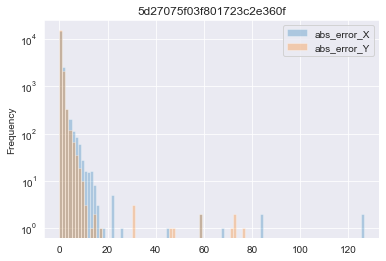

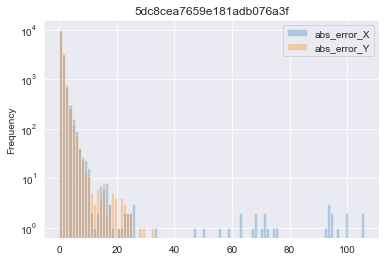

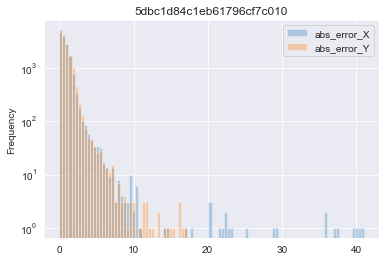

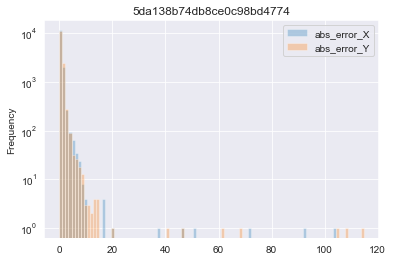

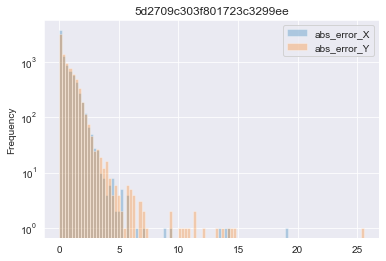

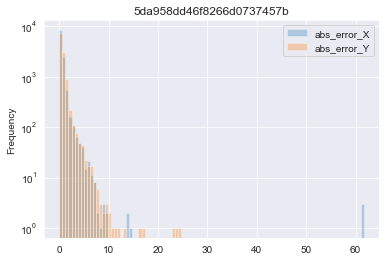

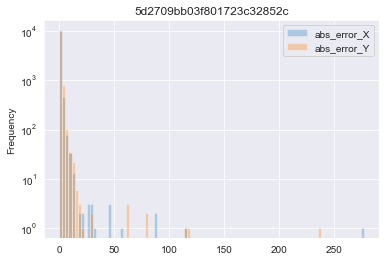

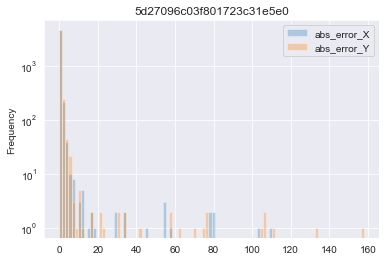

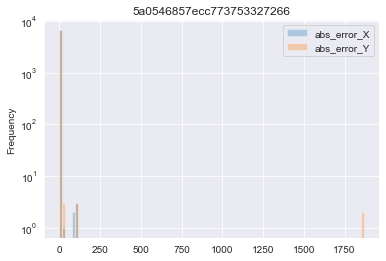

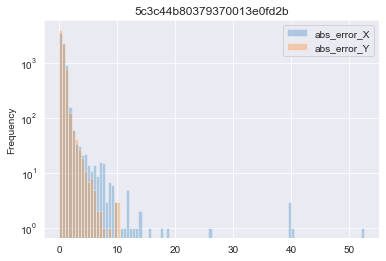

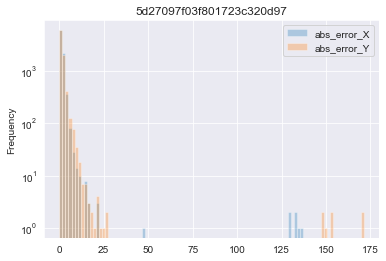

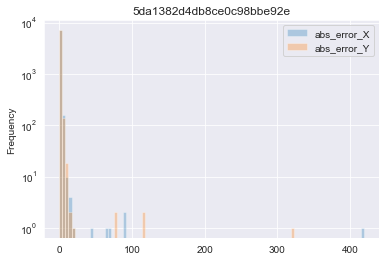

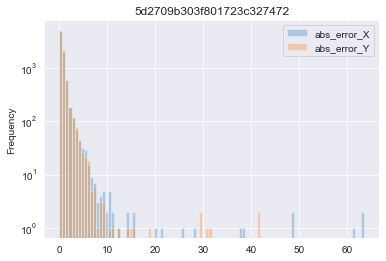

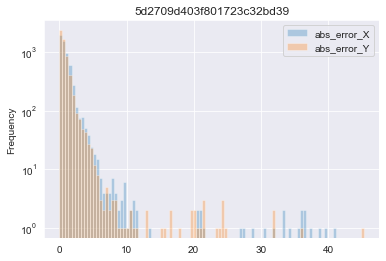

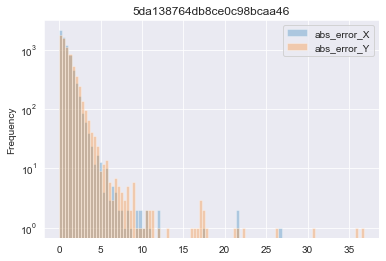

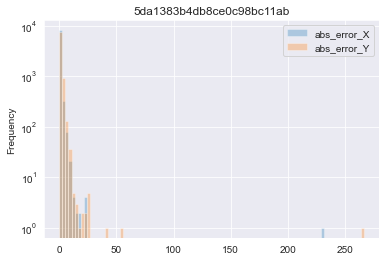

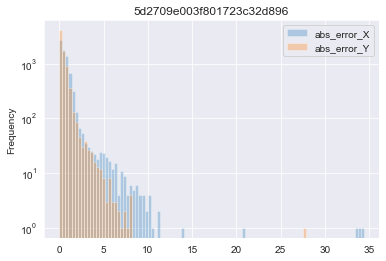

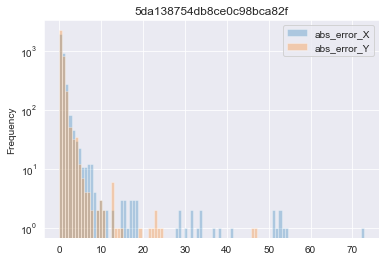

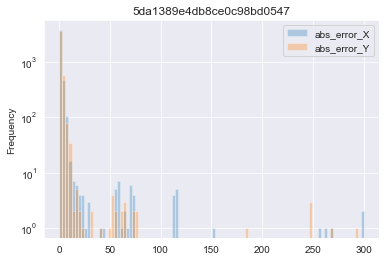

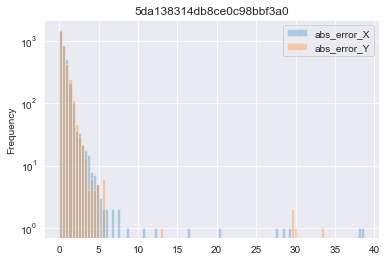

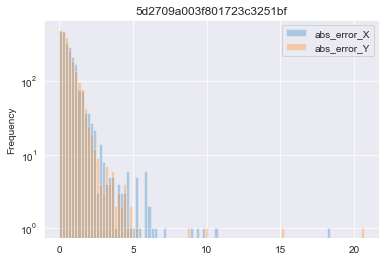

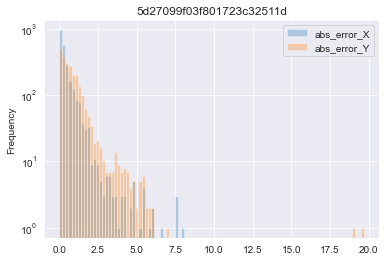

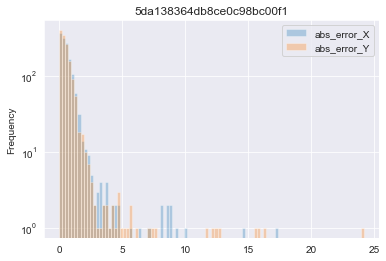

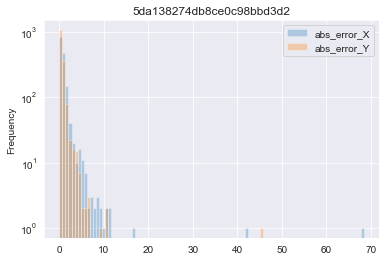

In [6]:
models24_xy = {}
train_val_comparison_xy = []
num_s = 0

site_ids_shapes = {"5d27075f03f801723c2e360f": (73141, 14063), "5dc8cea7659e181adb076a3f": (57849, 9733), "5dbc1d84c1eb61796cf7c010": (61727, 9043), "5da138b74db8ce0c98bd4774": (56668, 7075),
                   "5d2709c303f801723c3299ee": (33368, 11667), "5da958dd46f8266d0737457b": (47796, 7003), "5d2709bb03f801723c32852c": (44009, 4909), "5d27096c03f801723c31e5e0": (19337, 9933),
                   "5a0546857ecc773753327266": (26532, 6799), "5c3c44b80379370013e0fd2b": (29359, 6131), "5d27097f03f801723c320d97": (35121, 4985), "5da1382d4db8ce0c98bbe92e": (28975, 5729),
                   "5d2709b303f801723c327472": (32449, 3831), "5d2709d403f801723c32bd39": (23545, 4283), "5da138764db8ce0c98bcaa46": (27771, 3781), "5da1383b4db8ce0c98bc11ab": (34396, 3055),
                   "5d2709e003f801723c32d896": (29752, 2623), "5da138754db8ce0c98bca82f": (13795, 3259), "5da1389e4db8ce0c98bd0547": (17795, 2047), "5da138314db8ce0c98bbf3a0": (13122, 2429),
                   "5d2709a003f801723c3251bf": (9345, 2509), "5d27099f03f801723c32511d": (9700, 1855), "5da138364db8ce0c98bc00f1": (5555, 1649), "5da138274db8ce0c98bbd3d2": (6338, 985)}

site_ids_lrate = {"5d27075f03f801723c2e360f": 0.0, "5dc8cea7659e181adb076a3f": 0.0, "5dbc1d84c1eb61796cf7c010": 0.0, "5da138b74db8ce0c98bd4774": 0.0, 
                  "5d2709c303f801723c3299ee": 0.0, "5da958dd46f8266d0737457b": 0.0, "5d2709bb03f801723c32852c": 0.0, "5d27096c03f801723c31e5e0": 0.0, 
                  "5a0546857ecc773753327266": 0.002, "5c3c44b80379370013e0fd2b": 0.002, "5d27097f03f801723c320d97": 0.001, "5da1382d4db8ce0c98bbe92e": 0.002, 
                  "5d2709b303f801723c327472": 0.002, "5d2709d403f801723c32bd39": 0.002, "5da138764db8ce0c98bcaa46": 0.002, "5da1383b4db8ce0c98bc11ab": 0.001, 
                  "5d2709e003f801723c32d896": 0.002, "5da138754db8ce0c98bca82f": 0.004, "5da1389e4db8ce0c98bd0547": 0.003, "5da138314db8ce0c98bbf3a0": 0.004, 
                  "5d2709a003f801723c3251bf": 0.005, "5d27099f03f801723c32511d": 0.005, "5da138364db8ce0c98bc00f1": 0.009, "5da138274db8ce0c98bbd3d2": 0.008}

site_ids = ["5dbc1d84c1eb61796cf7c010"]

r_seeds = [123]#[1, 12, 123, 1234, 12345]

for r_seed in r_seeds:

    for site_id in site_ids_shapes.keys():#site_ids:#site_ids_num_bddsid: #site_ids:#site_ids_num_bddsid.keys(): #site_ids:
        num_s += 1
        print(f"Working on #{num_s}: Site-{site_id}")

        #========================================================================================       
        f_list, scaler_xy, encoder_xy, train_x, val_x, train_y_x, train_y_y, val_y_x, val_y_y = preprocess_data(load_data(site_id, 10000), target_type="XY0",
                                                                                                                data_fraction=1, random_state=r_seed,
                                                                                                                delay_lim=4000, rssi_lim=-94)
        train_y_xy = np.stack([train_y_x, train_y_y], axis=1)
        val_y_xy = np.stack([val_y_x, val_y_y], axis=1)

        model_xy = DNN(site_id=site_id, target_type="XY0",
                       train_x=train_x, val_x=val_x,
                       train_y=train_y_xy, val_y=val_y_xy,
                       w_f=0.1, drop=0.01, learning_rate=round(50/site_ids_shapes[site_id][0], 4), epochs=100, batch=0)


        models24_xy[site_id] = [f_list[5:], scaler_xy, encoder_xy, model_xy]

        #========================================================================================
        # sanity check section
        predict_columns = ["predict_X", "predict_Y"]
        real_columns = ["real_X", "real_Y"]
        col_dic = {0: "_X", 1: "_Y"}

        predictions_train_xy = pd.DataFrame(model_xy.predict(train_x), columns=predict_columns)
        comparison_train_xy = pd.concat([pd.DataFrame(train_y_xy, columns=real_columns),
                                      predictions_train_xy], axis=1)
        predictions_val_xy = pd.DataFrame(model_xy.predict(val_x), columns=predict_columns)
        comparison_val_xy = pd.concat([pd.DataFrame(val_y_xy, columns=real_columns),
                                    predictions_val_xy], axis=1)

        for col_i, col in enumerate(predict_columns):
            for train_valid in [comparison_train_xy, comparison_val_xy]:
                train_valid["abs_error"+col_dic[col_i]] = np.abs(train_valid[real_columns[col_i]] - train_valid[col])

        for train_valid in [comparison_train_xy, comparison_val_xy]:
            mean_error = np.sqrt(np.power(train_valid["abs_error_X"], 2) + np.power(train_valid["abs_error_Y"], 2))
            train_valid["mean_abs_error"] = mean_error.cumsum()/train_valid.shape[0]

        print(f"Predictions (train/validation) #{num_s}: Site-{site_id}")
        #display(comparison_train_xy[["mean_abs_error"]].tail(1))
        #display(comparison_val_xy[["mean_abs_error"]].tail(1))

        train_val_comparison_xy.append([comparison_train_xy, comparison_val_xy])
        #========================================================================================
        display(comparison_val_xy.describe())
        display(comparison_val_xy[(comparison_val_xy.abs_error_X > 20) | (comparison_val_xy.abs_error_Y > 20)])
        
        comparison_val_xy[["abs_error_X", "abs_error_Y"]].plot.hist(bins=100, logy=True, alpha=0.3, title=site_id)
        
        keras.backend.clear_session()
        #break
    print("Finished fitting")
    calculate_global_metrics(train_val_comparison_xy)
    save_models(models24_xy, "XY0", f"models24_Fcat_XY0_R{r_seed}")
    print("Finished Models Saving")
    #%tensorboard --logdir log/Neurals  # commandline to start tensorboard